# **STEP 0: IMPORT LIBRARIES**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer  
from sklearn.preprocessing import OneHotEncoder      
from sklearn.model_selection import KFold   
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from statistics import mean
from sklearn.model_selection import train_test_split
import joblib 
import lightgbm as lgb
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit, StratifiedKFold, StratifiedShuffleSplit
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold, StratifiedKFold

# Additional useful imports
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import learning_curve
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, median_absolute_error
import seaborn as sns
from scipy import stats
import warnings
import os
import yfinance as yf
import ta

# Forex Data Analysis and Prediction

This script is designed to perform comprehensive data analysis and predictive modeling on Forex data. It leverages historical data and technical indicators to forecast Forex prices using various machine learning models.

## Table of Contents

1. [Requirements](#requirements)
2. [Installation](#installation)
3. [Usage](#usage)
4. [Features](#features)
5. [Models](#models)
6. [Output](#output)
7. [Evaluation and Fine-Tuning](#evaluation-and-fine-tuning)

## Requirements

- Python 3.x
- Libraries: 
  - pandas
  - numpy
  - matplotlib
  - seaborn
  - scikit-learn
  - lightgbm
  - xgboost
  - yfinance
  - ta (Technical Analysis Library in Python)
  - joblib

## Installation

1. Clone the repository:
   ```bash
   git clone https://github.com/yourusername/forex-prediction.git
   cd forex-prediction
Install the required libraries:
Sao chép
pip install -r requirements.txt
Usage
Run the script to perform data crawling, feature engineering, and model training:

Sao chép
python forex_prediction.py
The script will output the results of various models and save trained models in the models directory.

Features
Data Crawling
Yahoo Finance API: Utilizes the yfinance library to download historical Forex data.
Data Storage: Saves the fetched data into CSV files for further processing.
Feature Engineering
Technical Indicators: Computes a range of technical indicators to enhance the predictive power of models:
Moving Averages (MA): Calculates 10, 50, and 200-day moving averages to identify trends.
Relative Strength Index (RSI): Measures the speed and change of price movements.
MACD (Moving Average Convergence Divergence): Used to identify potential buy and sell signals.
Bollinger Bands: Helps identify overbought or oversold conditions in the market.
Average True Range (ATR): Indicates market volatility.
And many more: Including ADX, Aroon, Stochastic Oscillator, etc.
Data Preprocessing
Handling Missing Values: Uses interpolation and other imputation methods to fill missing data points.
Normalization and Scaling: Standardizes features to ensure that they contribute equally to the model performance.
Models
The script implements and evaluates several machine learning models:

LightGBM Regressor: A gradient boosting framework that uses tree-based learning algorithms, known for its speed and efficiency.

XGBoost Regressor: An optimized distributed gradient boosting library designed to be highly efficient, flexible, and portable.

Decision Tree Regressor: A non-parametric supervised learning method used for regression that predicts the value of a target variable by learning simple decision rules inferred from the data features.

Polynomial Regression: Extends linear regression by considering polynomial features, allowing the model to fit a wider range of curves.

Linear Regression: A basic but powerful model that assumes a linear relationship between input features and the target variable.

Random Forest Regressor: An ensemble method that builds multiple decision trees and merges them to get a more accurate and stable prediction.

K-Nearest Neighbors Regressor: A non-parametric method that predicts the target by averaging the values of the k-nearest neighbors.

Support Vector Regressor (SVR): Uses the principles of support vector machines for regression challenges, effective in high-dimensional spaces.

Output
Predicted Forex Prices: The primary output of the script is the predicted closing prices of the specified Forex pair(s). These predictions are generated based on the historical data and technical indicators processed by the models.
Evaluation Metrics: The script also provides evaluation metrics such as R2 score and RMSE to assess the accuracy and reliability of the predictions.
Evaluation and Fine-Tuning
Evaluation
Cross-Validation: Uses K-Fold cross-validation to assess the robustness of the models. It splits the dataset into k different subsets and trains the model k times, each time using a different subset as the test set.
Residual Analysis: Plots residual distributions to visually assess the performance and fit of the models.
Fine-Tuning
Grid Search: Utilizes GridSearchCV to perform hyperparameter tuning, systematically building and evaluating models for each combination of algorithm parameters specified in a grid.
Performance Metrics: Evaluates models using R2 score and RMSE to quantify the accuracy of predictions.
Notes
Ensure that the dataset directory and model storage paths are correctly set up in the script.
Modify the forex_label list to include additional Forex pairs if needed.
Sao chép

This Markdown cell can be copied into a Jupyter Notebook or any Markdown editor to provide a comprehensive overview of the script's functionality.
nhồi nó vào 1 cell

GPT-4o
Sure! Here is the entire README content formatted as a single Markdown cell:

Sao chép
# Forex Data Analysis and Prediction

This script is designed to perform comprehensive data analysis and predictive modeling on Forex data. It leverages historical data and technical indicators to forecast Forex prices using various machine learning models.

## Table of Contents

1. [Requirements](#requirements)
2. [Installation](#installation)
3. [Usage](#usage)
4. [Features](#features)
5. [Models](#models)
6. [Output](#output)
7. [Evaluation and Fine-Tuning](#evaluation-and-fine-tuning)

## Requirements

- Python 3.x
- Libraries: 
  - pandas
  - numpy
  - matplotlib
  - seaborn
  - scikit-learn
  - lightgbm
  - xgboost
  - yfinance
  - ta (Technical Analysis Library in Python)
  - joblib

## Installation

1. Clone the repository:
   ```bash
   git clone https://github.com/yourusername/forex-prediction.git
   cd forex-prediction
Install the required libraries:
Sao chép
pip install -r requirements.txt
Usage
Run the script to perform data crawling, feature engineering, and model training:

Sao chép
python forex_prediction.py
The script will output the results of various models and save trained models in the models directory.

Features
Data Crawling
Yahoo Finance API: Utilizes the yfinance library to download historical Forex data.
Data Storage: Saves the fetched data into CSV files for further processing.
Feature Engineering
Technical Indicators: Computes a range of technical indicators to enhance the predictive power of models:
Moving Averages (MA): Calculates 10, 50, and 200-day moving averages to identify trends.
Relative Strength Index (RSI): Measures the speed and change of price movements.
MACD (Moving Average Convergence Divergence): Used to identify potential buy and sell signals.
Bollinger Bands: Helps identify overbought or oversold conditions in the market.
Average True Range (ATR): Indicates market volatility.
And many more: Including ADX, Aroon, Stochastic Oscillator, etc.
Data Preprocessing
Handling Missing Values: Uses interpolation and other imputation methods to fill missing data points.
Normalization and Scaling: Standardizes features to ensure that they contribute equally to the model performance.
Models
The script implements and evaluates several machine learning models:

LightGBM Regressor: A gradient boosting framework that uses tree-based learning algorithms, known for its speed and efficiency.

XGBoost Regressor: An optimized distributed gradient boosting library designed to be highly efficient, flexible, and portable.

Decision Tree Regressor: A non-parametric supervised learning method used for regression that predicts the value of a target variable by learning simple decision rules inferred from the data features.

Polynomial Regression: Extends linear regression by considering polynomial features, allowing the model to fit a wider range of curves.

Linear Regression: A basic but powerful model that assumes a linear relationship between input features and the target variable.

Random Forest Regressor: An ensemble method that builds multiple decision trees and merges them to get a more accurate and stable prediction.

K-Nearest Neighbors Regressor: A non-parametric method that predicts the target by averaging the values of the k-nearest neighbors.

Support Vector Regressor (SVR): Uses the principles of support vector machines for regression challenges, effective in high-dimensional spaces.

Output
Predicted Forex Prices: The primary output of the script is the predicted closing prices of the specified Forex pair(s). These predictions are generated based on the historical data and technical indicators processed by the models.
Evaluation Metrics: The script also provides evaluation metrics such as R2 score and RMSE to assess the accuracy and reliability of the predictions.
Evaluation and Fine-Tuning
Evaluation
Cross-Validation: Uses K-Fold cross-validation to assess the robustness of the models. It splits the dataset into k different subsets and trains the model k times, each time using a different subset as the test set.
Residual Analysis: Plots residual distributions to visually assess the performance and fit of the models.
Fine-Tuning
Grid Search: Utilizes GridSearchCV to perform hyperparameter tuning, systematically building and evaluating models for each combination of algorithm parameters specified in a grid.
Performance Metrics: Evaluates models using R2 score and RMSE to quantify the accuracy of predictions.
Notes
Ensure that the dataset directory and model storage paths are correctly set up in the script.
Modify the forex_label list to include additional Forex pairs if needed.

# **STEP 1: DEFINE LABEL**

In [3]:
forex_label = ['EURCAD=X']

# **STEP 2: GET FOREX DATA CRAWLING**

**2.1: Crawl all FOREX data needed**

**2.1.1. Function to crawl Forex data**

In [4]:
def crawl_forex_data(forex_pair, directory='Dataset'):
    """
    Crawls historical data for a given Forex pair and saves it to a CSV file.

    Parameters:
    forex_pair (str): The Forex pair symbol to download data for (e.g., 'EURUSD=X').
    directory (str): The directory where the data should be saved.

    Returns:
    str: Path to the saved CSV file.
    pd.DataFrame: The crawled data as a Pandas DataFrame.
    """
    # Create directory if it doesn't exist
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Download historical data for the Forex pair
    print(f"Downloading data for {forex_pair}...")
    data = yf.download(forex_pair, period="max", interval='1d')
    data.reset_index(inplace=True)  # Reset index to ensure 'Date' is a normal column

    # Save data to CSV
    file_path = os.path.join(directory, f'{forex_pair}_data.csv')
    data.to_csv(file_path, index=False)
    print(f"Saved data for {forex_pair} at {file_path}")

    return file_path, data

**2.2. Check crawling result**

In [5]:
file_path, data = crawl_forex_data(forex_label)

# Display the first 10 rows of the DataFrame
print(data.head(5))
print(data.info())

# Calculate and print statistics of NaN values
nan_stats = data.isna().sum()
total_nans = nan_stats.sum()

print("\nStatistics of NaN values in the DataFrame:")
print(nan_stats)
print(f"\nTotal number of NaN values: {total_nans}")

[*********************100%***********************]  1 of 1 completed

Saved data for ['EURCAD=X'] at Dataset\['EURCAD=X']_data.csv
        Date    Open    High     Low   Close  Adj Close  Volume
0 2003-12-01  1.5616  1.5667  1.5542  1.5596     1.5596       0
1 2003-12-02  1.5598  1.5708  1.5590  1.5670     1.5670       0
2 2003-12-03  1.5665  1.5762  1.5648  1.5759     1.5759       0
3 2003-12-04  1.5754  1.5909  1.5690  1.5829     1.5829       0
4 2003-12-05  1.5833  1.5886  1.5752  1.5876     1.5876       0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5413 entries, 0 to 5412
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       5413 non-null   datetime64[ns]
 1   Open       5413 non-null   float64       
 2   High       5413 non-null   float64       
 3   Low        5413 non-null   float64       
 4   Close      5413 non-null   float64       
 5   Adj Close  5413 non-null   float64       
 6   Volume     5413 non-null   int64         
dtypes: datetime64[ns](1),

**STEP 3: FEATURE ENGINEERING**

In [6]:
# Feature Engineering 
# Calculate moving averages
if 'Close' in data.columns:
    if len(data) >= 10: data['MA_10'] = data['Close'].rolling(window=10).mean()
    if len(data) >= 50: data['MA_50'] = data['Close'].rolling(window=50).mean()
    if len(data) >= 200: data['MA_200'] = data['Close'].rolling(window=200).mean()

# Calculate RSI
data['RSI'] = ta.momentum.RSIIndicator(data['Close'], window=14).rsi()

# Calculate MACD
data['MACD'] = ta.trend.MACD(data['Close']).macd()

# Calculate Bollinger Bands
bollinger = ta.volatility.BollingerBands(data['Close'])
data['BB_High'] = bollinger.bollinger_hband()
data['BB_Low'] = bollinger.bollinger_lband()

# Calculate Bollinger BandWidth (BBTrend)
data['BB_Width'] = (data['BB_High'] - data['BB_Low']) / data['Close']

# 24-hour Volume
data['Volume_24h'] = data['Volume'].rolling(window=1440).sum()

# Accumulation/Distribution Line (ADL)
data['ADL'] = ta.volume.AccDistIndexIndicator(data['High'], data['Low'], data['Close'], data['Volume']).acc_dist_index()

# Aroon Indicator
aroon = ta.trend.AroonIndicator(data['Close'], data['Low'], window=25)
data['Aroon_Up'] = aroon.aroon_up()
data['Aroon_Down'] = aroon.aroon_down()

# Average Directional Index (ADX)
data['ADX'] = ta.trend.ADXIndicator(data['High'], data['Low'], data['Close'], window=14).adx()

# Average True Range (ATR)
data['ATR'] = ta.volatility.AverageTrueRange(data['High'], data['Low'], data['Close'], window=14).average_true_range()

# Awesome Oscillator (AO)
data['AO'] = ta.momentum.AwesomeOscillatorIndicator(data['High'], data['Low'], window1=5, window2=34).awesome_oscillator()

# Balance of Power (BOP)
data['BOP'] = (data['Close'] - data['Open']) / (data['High'] - data['Low'])

# Bull Bear Power
data['Bull_Power'] = data['High'] - data['MA_50']
data['Bear_Power'] = data['Low'] - data['MA_50']

# Chaikin Oscillator
data['Chaikin_Osc'] = data['ADL'].ewm(span=3).mean() - data['ADL'].ewm(span=10).mean()

# Stochastic Oscillator (Stoch)
stoch = ta.momentum.StochasticOscillator(data['High'], data['Low'], data['Close'], window=14)
data['Stoch_Osc'] = stoch.stoch()

# Commodity Channel Index (CCI)
data['CCI'] = ta.trend.CCIIndicator(data['High'], data['Low'], data['Close'], window=20).cci()

# Vortex Oscillator
vortex = ta.trend.VortexIndicator(data['High'], data['Low'], data['Close'], window=14)
data['Vortex_Plus'] = vortex.vortex_indicator_pos()
data['Vortex_Minus'] = vortex.vortex_indicator_neg()

**3.2. Check NaN values before interpolation**

In [7]:
nan_stats_before = data.isna().sum()
total_nans_before = nan_stats_before.sum()
print("\nStatistics of NaN values before interpolation:")
print(nan_stats_before)
print(f"Total number of NaN values before interpolation: {total_nans_before}")


Statistics of NaN values before interpolation:
Date               0
Open               0
High               0
Low                0
Close              0
Adj Close          0
Volume             0
MA_10              9
MA_50             49
MA_200           199
RSI               13
MACD              25
BB_High           19
BB_Low            19
BB_Width          19
Volume_24h      1439
ADL                0
Aroon_Up          25
Aroon_Down        25
ADX                0
ATR                0
AO                33
BOP                4
Bull_Power        49
Bear_Power        49
Chaikin_Osc        0
Stoch_Osc         13
CCI               19
Vortex_Plus       14
Vortex_Minus      14
dtype: int64
Total number of NaN values before interpolation: 2036


**3.3. Use Interpolation to fill missing values**

**Why use Interpolation ?**

In [8]:
# Interpolate missing data
data.interpolate(method='linear', inplace=True)

In [9]:
# Check how many rows remain after interpolation
nan_stats_after = data.isna().sum()
total_nans_after = nan_stats_after.sum()
print("\nStatistics of NaN values after interpolation:")
# print(nan_stats_after)
print(f"Total number of NaN values after interpolation: {total_nans_after}")


Statistics of NaN values after interpolation:
Total number of NaN values after interpolation: 2032


**NOTE: As we can see, after using the interpolation, there are still many NaN values**

**3.4: Detect NaN values left and fill them**

In [10]:
# If there are still NaN values, use another method to fill them
if total_nans_after > 0:
    # Fill remaining NaN values with forward fill
    data.fillna(method='ffill', inplace=True)
    
    # If still NaN, use backward fill
    if data.isna().sum().sum() > 0:
        data.fillna(method='bfill', inplace=True)

C:\Users\Admin\AppData\Local\Temp\ipykernel_20364\1693104163.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_20364\1693104163.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)


**3.5. Examine for left over NaN result**

In [11]:
# Final check on NaN values
nan_stats_final = data.isna().sum()
total_nans_final = nan_stats_final.sum()
print("\n----Statistics of NaN values after final filling----")
print(f"Total number of NaN values after final filling: {total_nans_final}")

# Check how many rows remain after dropping NaN values
data.dropna(subset=['Close', 'Open'], inplace=True)
print(f"Number of rows after dropna: {len(data)}")


----Statistics of NaN values after final filling----
Total number of NaN values after final filling: 0
Number of rows after dropna: 5413


**3.6. Define list of indicators**

In [12]:
# List of indicators to plot
indicators = [
    'MA_10', 'MA_50', 'MA_200',
    'RSI', 'MACD',
    'BB_High', 'BB_Low',
    'ADX', 'ATR', 'AO',
    'BOP', 'Bull_Power', 'Bear_Power',
    'Chaikin_Osc',
    'Stoch_Osc', 'CCI',
    'Vortex_Plus', 'Vortex_Minus'
    ]

**STEP 4: PLOTTING FOR EVALUATION**

**Function to plot year data**

In [13]:
def plot_yearly_data(data, title='Yearly Price Data'):
    plt.figure(figsize=(14, 7))
    plt.plot(data['Date'], data['Close'], label='Close Price', color='blue')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()
    plt.show()

**Functions to plot prices vs indicators**

In [14]:
def plot_prices_vs_indicators(data, indicator, title):
    plt.figure(figsize=(14, 7))
    plt.plot(data['Date'], data['Close'], label='Close Price', color='blue')
    plt.plot(data['Date'], data[indicator], label=indicator, color='orange')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price / Indicator Value')
    plt.legend()
    plt.grid()
    plt.show()

**Function to plot out Label Price vs other forex pairs**

In [15]:
# **Function to plot out Label Price vs Other Forex Pairs**
def plot_label_vs_other_forex(data, label, other_pairs):
    plt.figure(figsize=(14, 7))
    
    # Check if the label exists in the DataFrame
    if label not in data.columns:
        print(f"Label '{label}' not found in DataFrame columns: {data.columns}")
        return

    plt.plot(data['Date'], data[label], label=label, color='blue')
    
    for pair in other_pairs:
        pair_close = f'{pair}_Close'
        if pair_close in data.columns:  # Ensure the pair exists in the DataFrame
            plt.plot(data['Date'], data[pair_close], label=f'{pair} Close', linestyle='--')
    
    plt.title(f'{label} vs Other Forex Pairs')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()
    plt.show()

**4.1. Plot out yearly data**

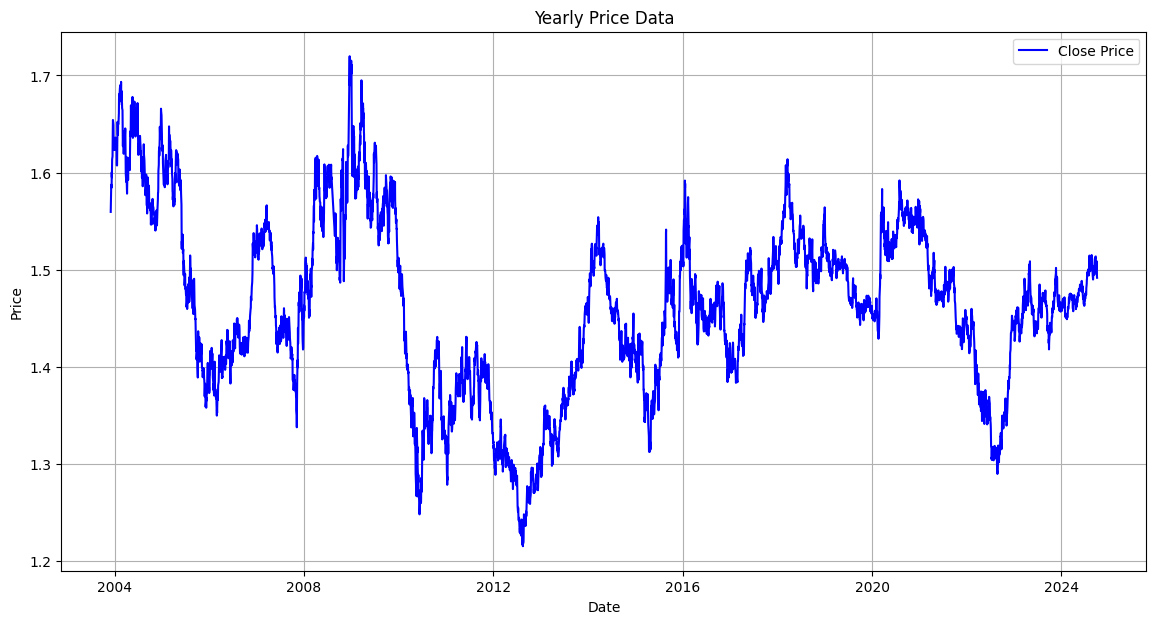

In [16]:
# Plot yearly data
plot_yearly_data(data)

**4..2. Plot out indicators vs price**

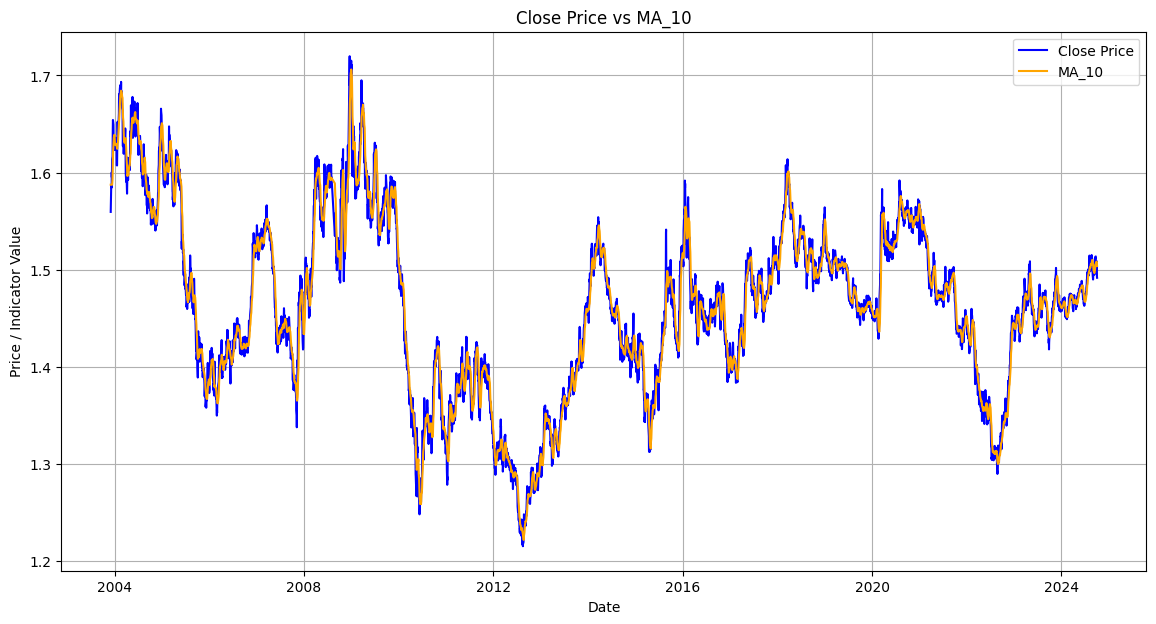

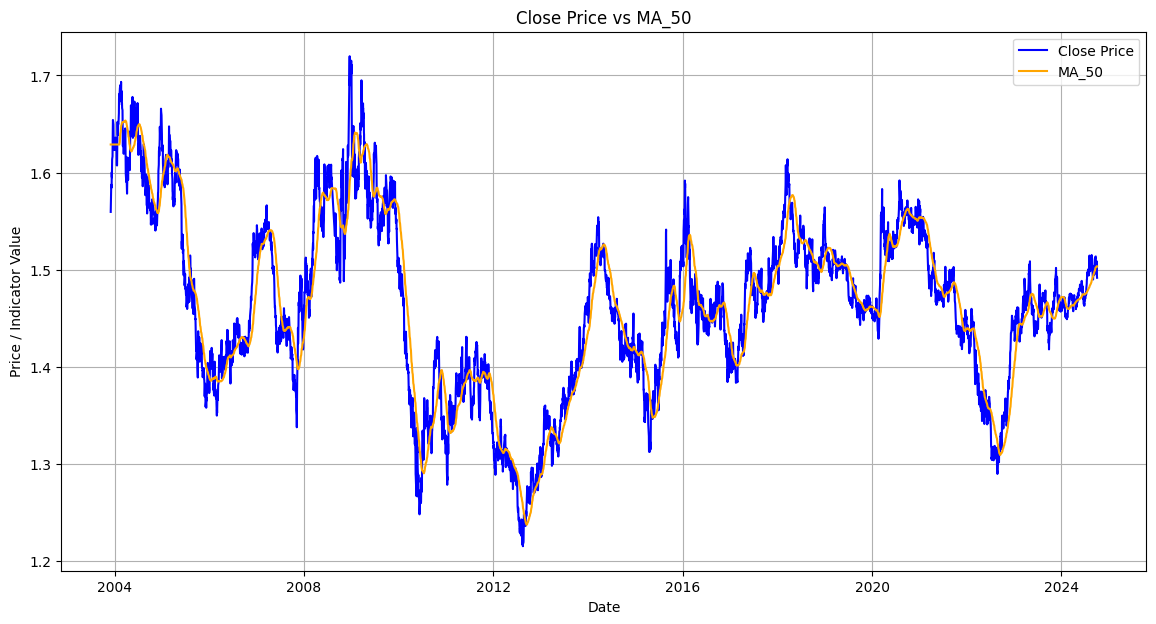

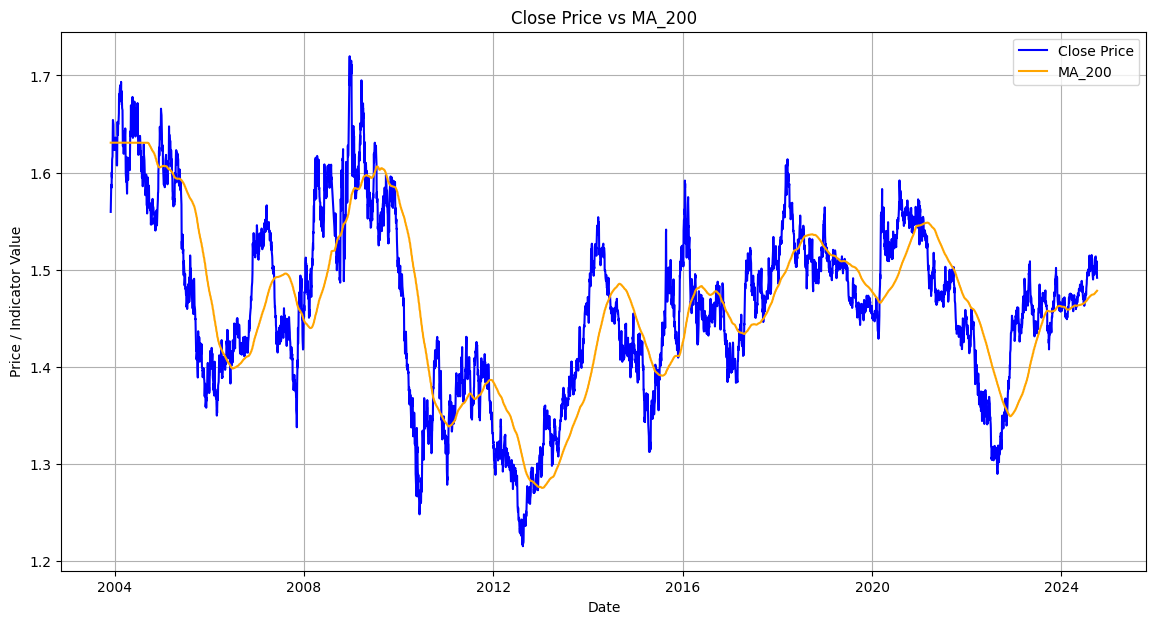

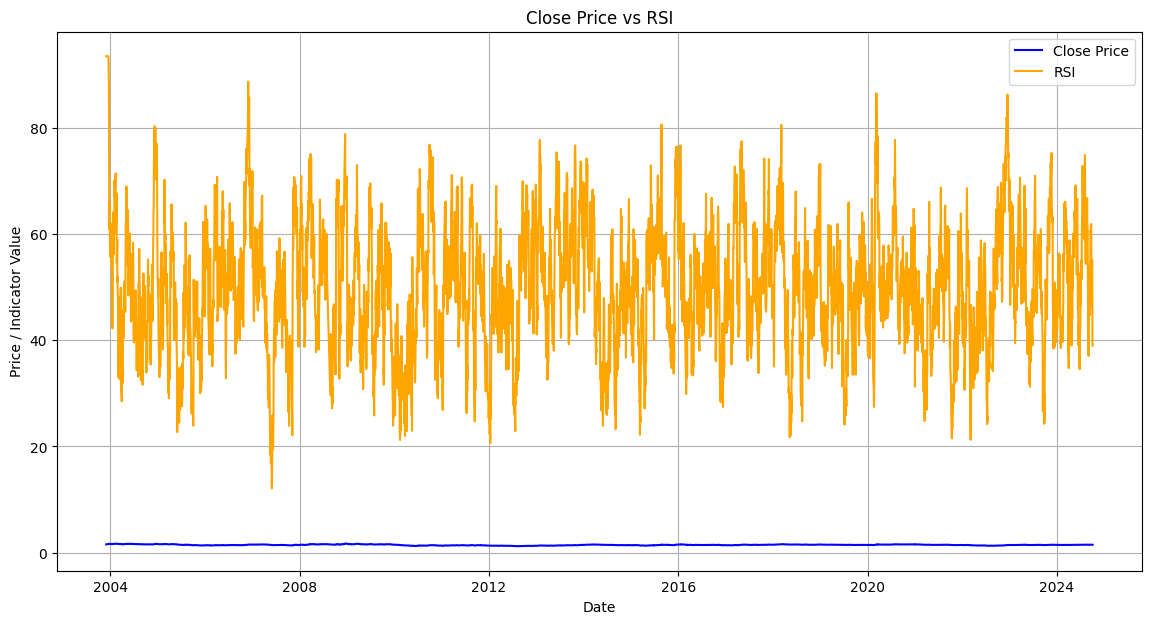

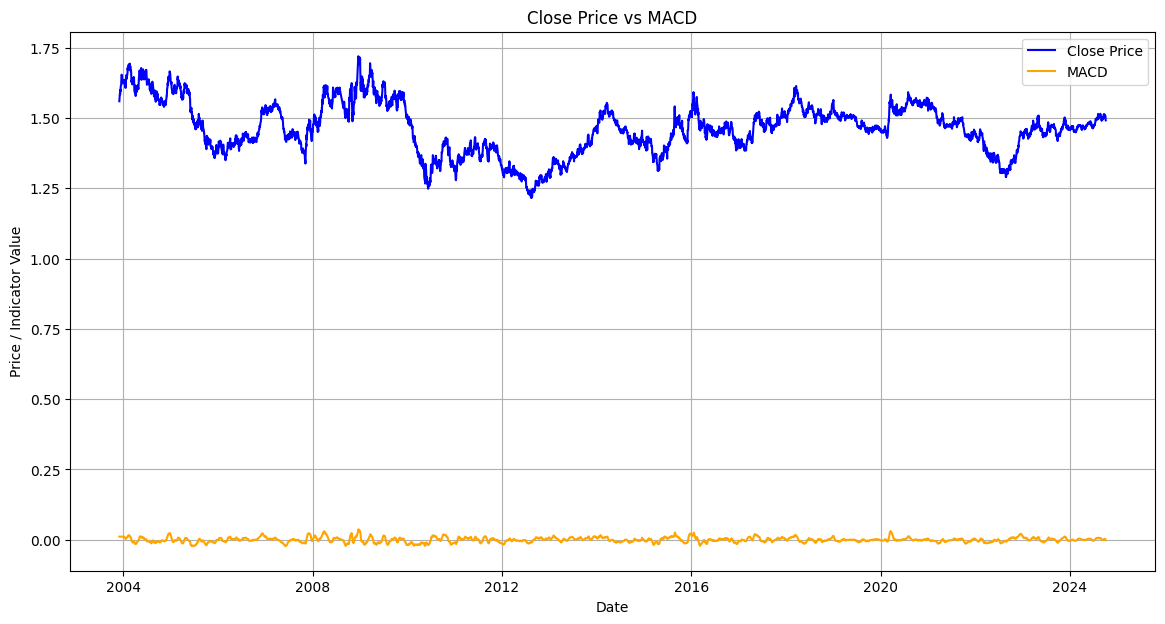

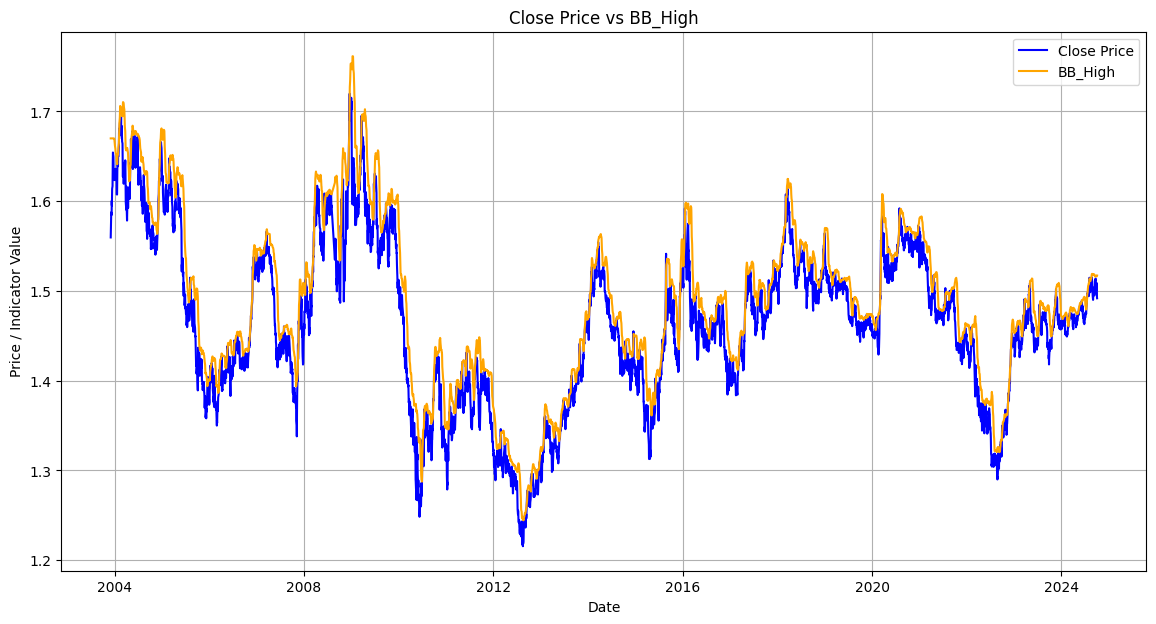

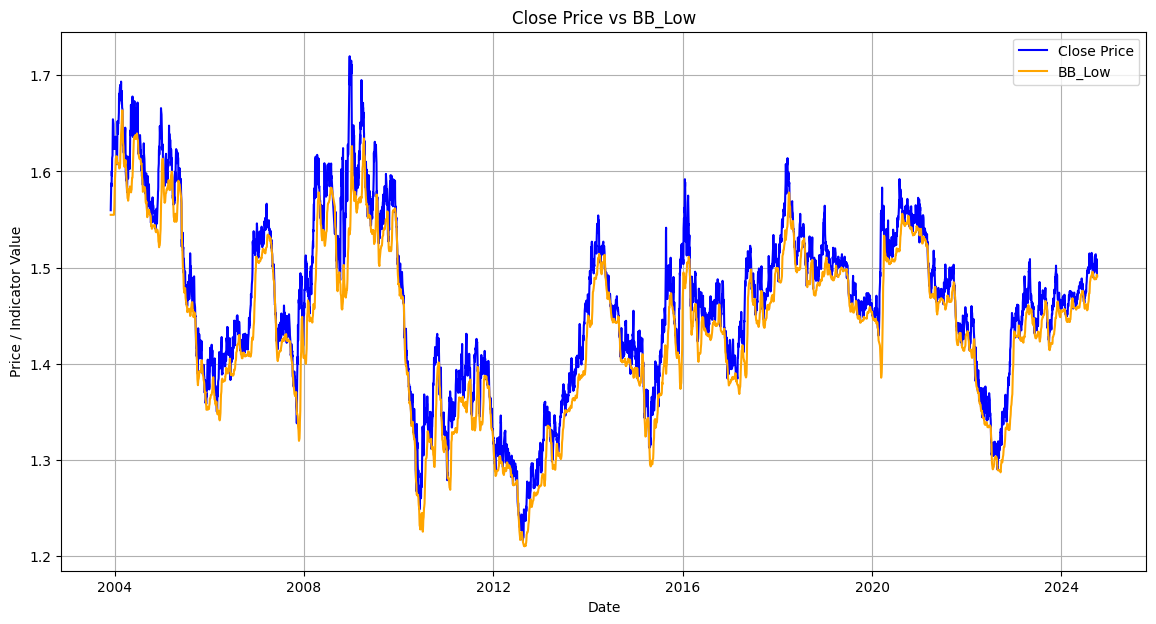

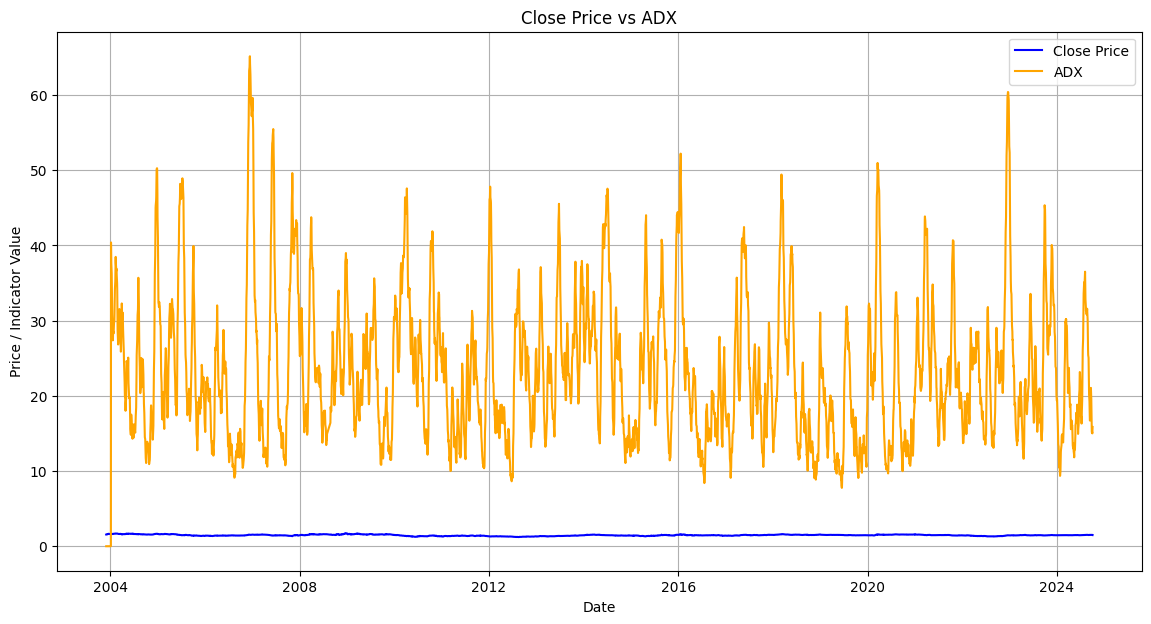

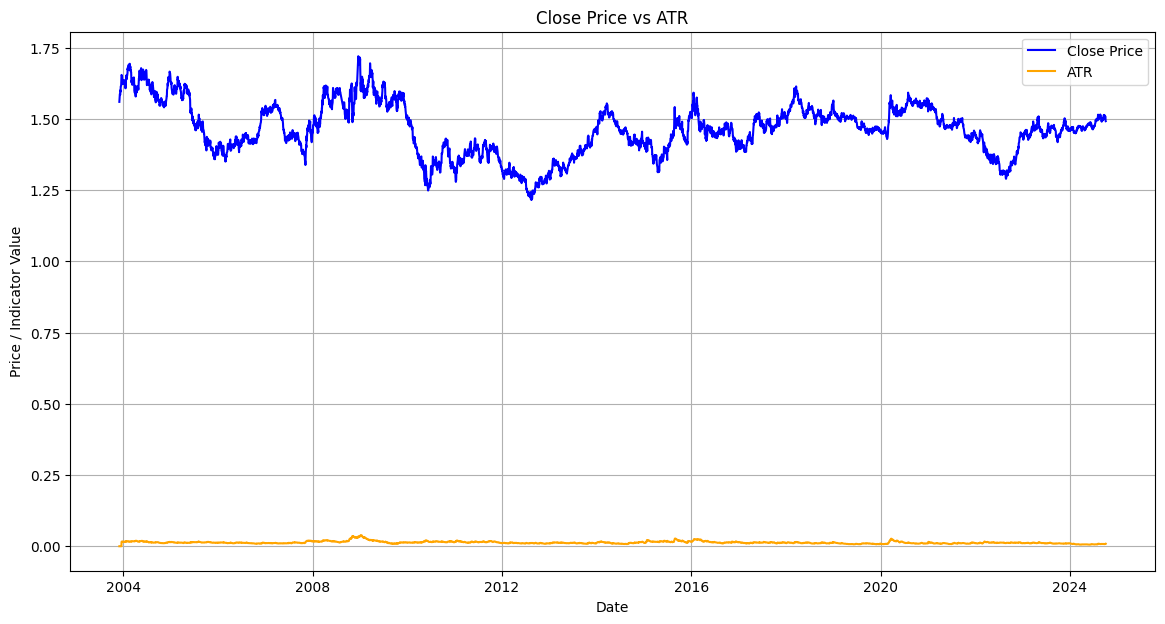

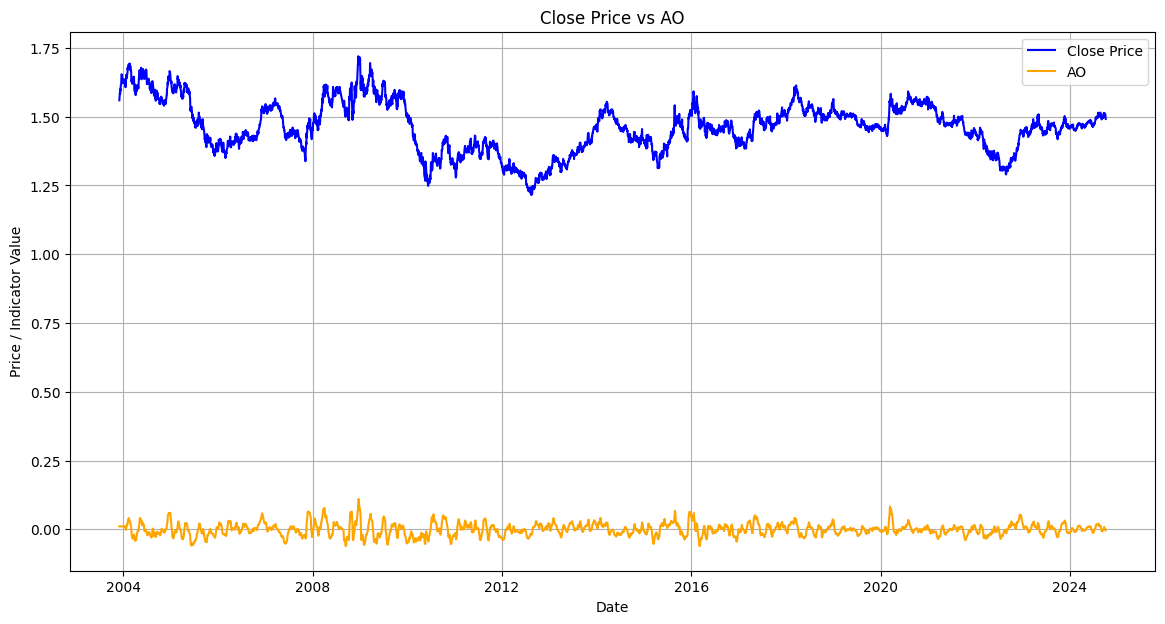

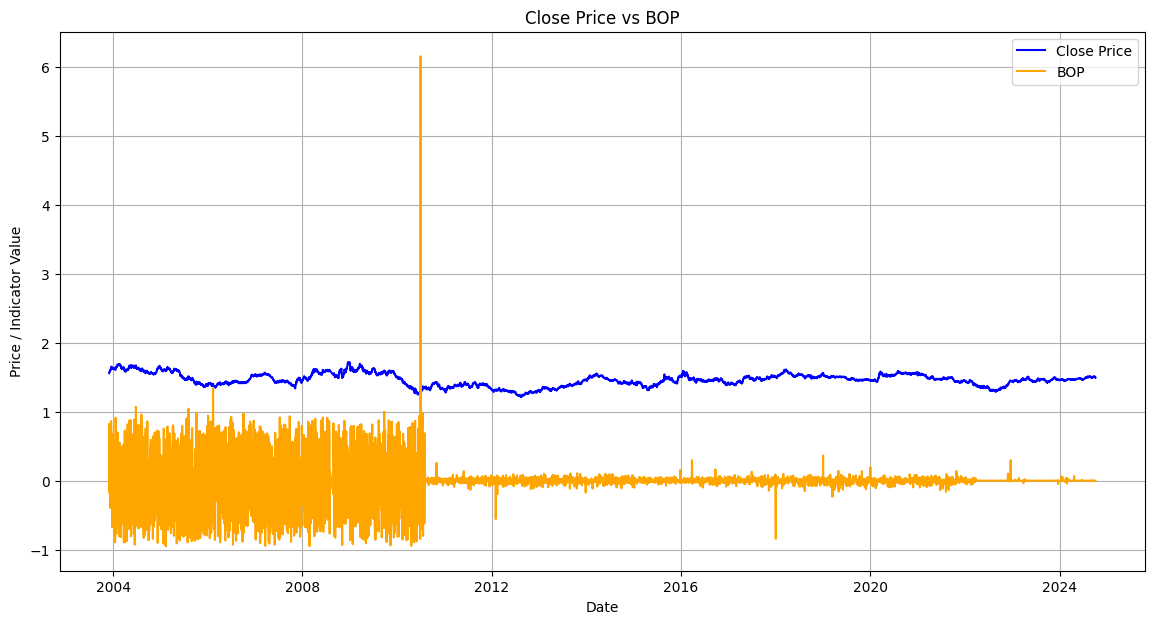

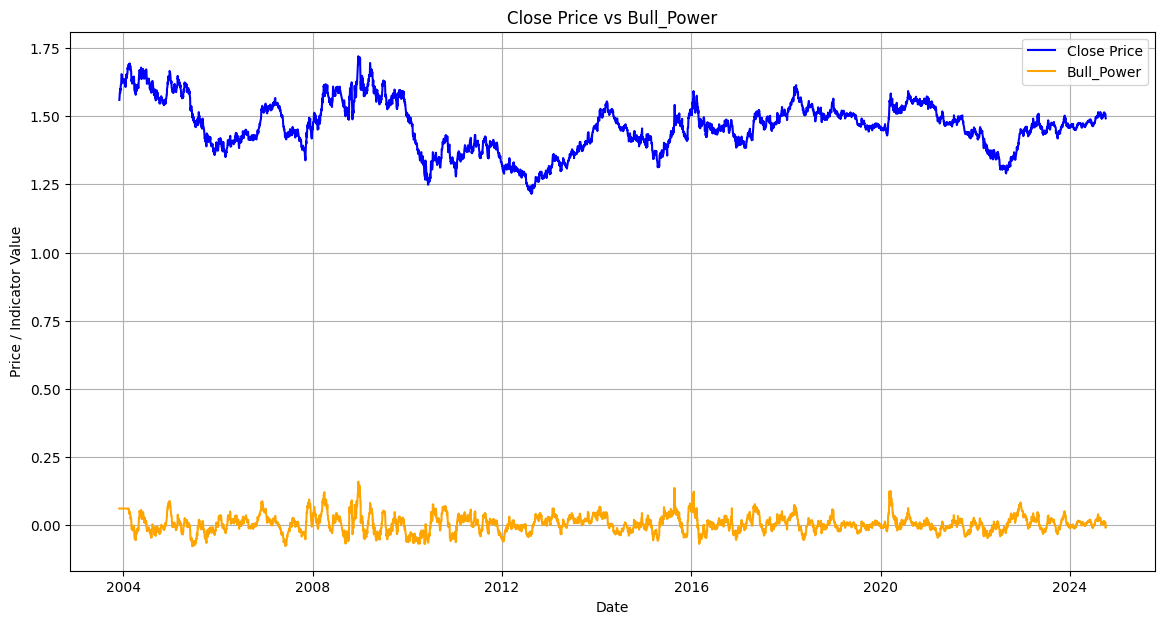

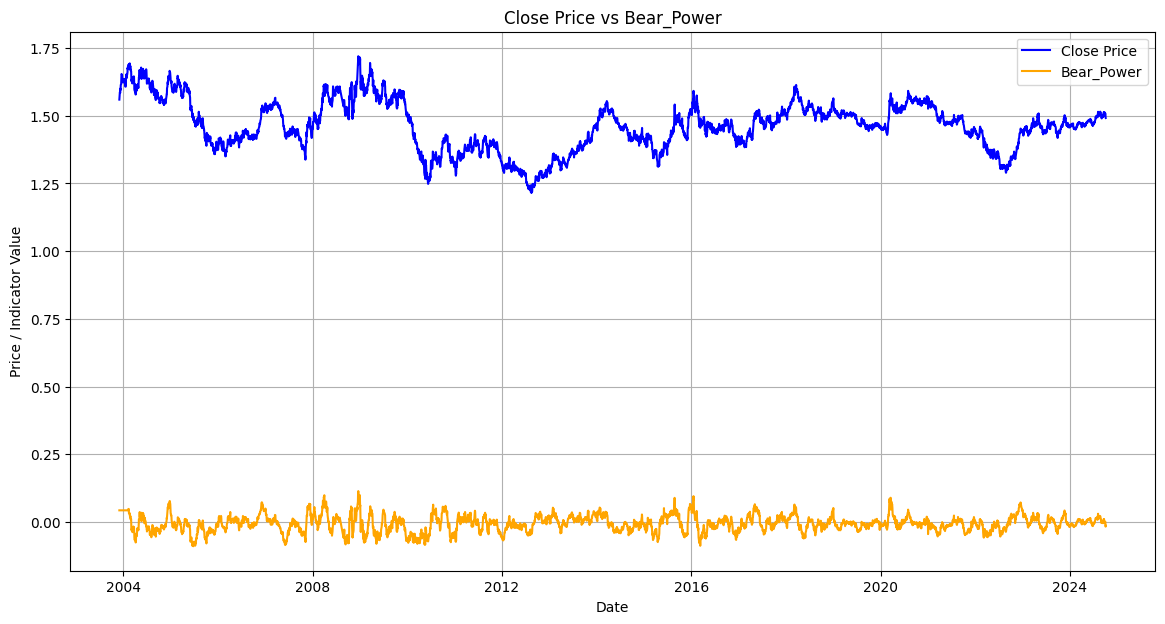

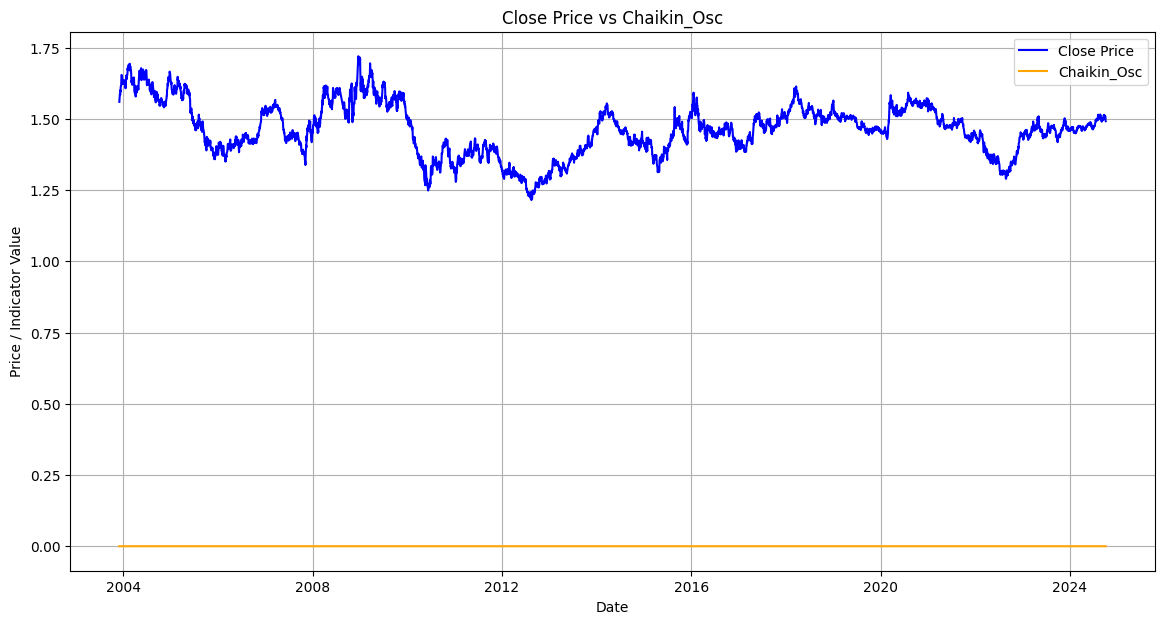

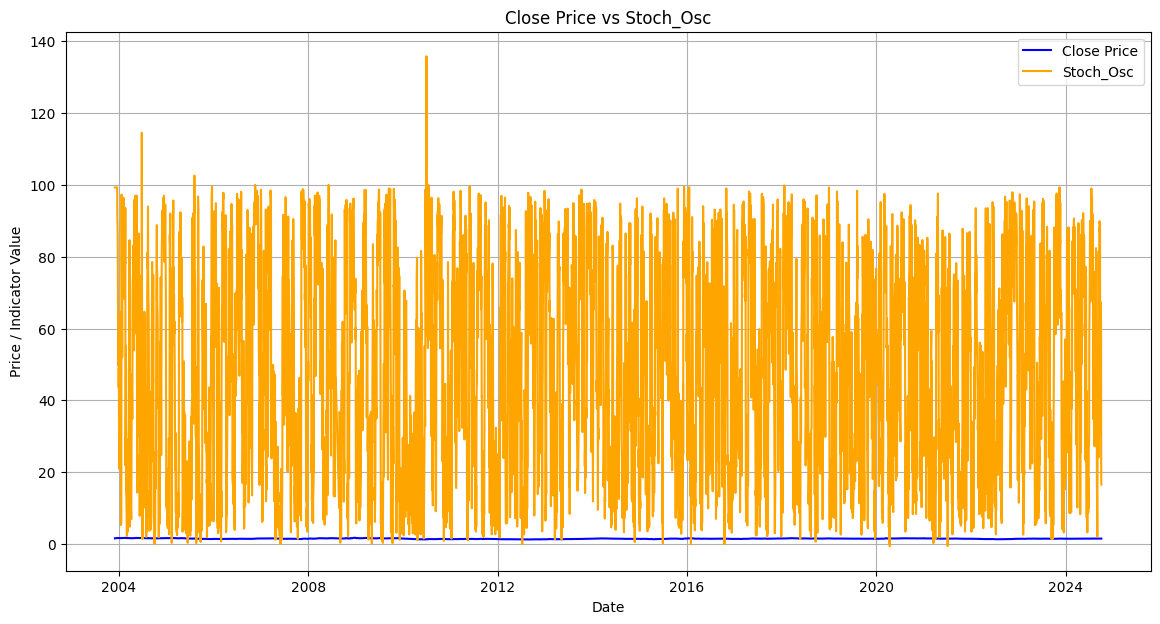

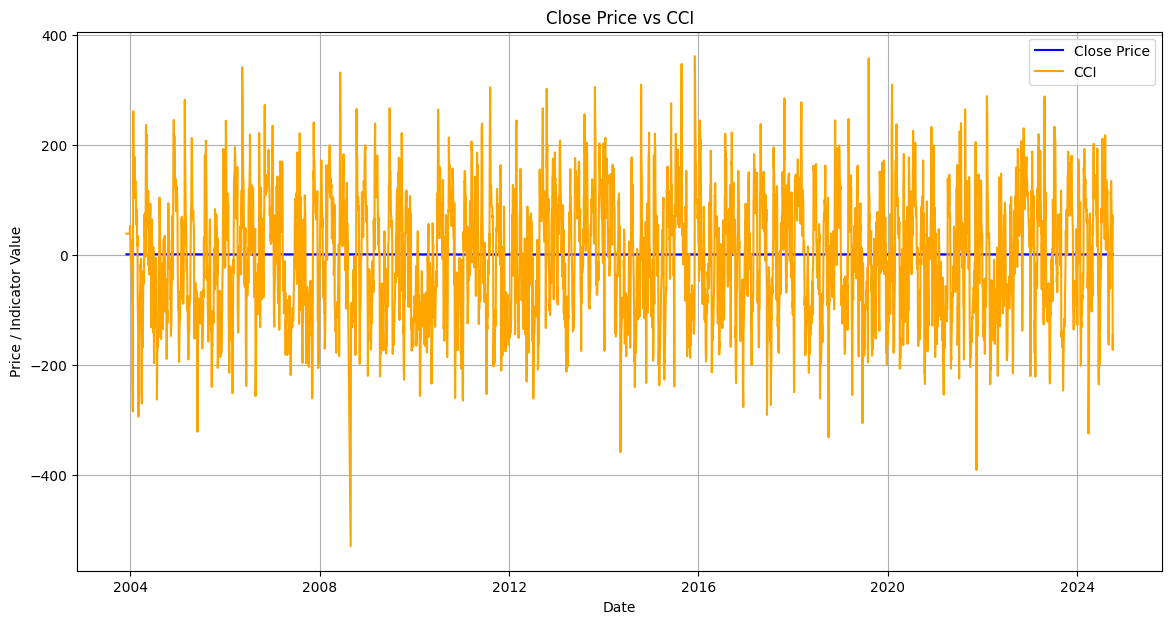

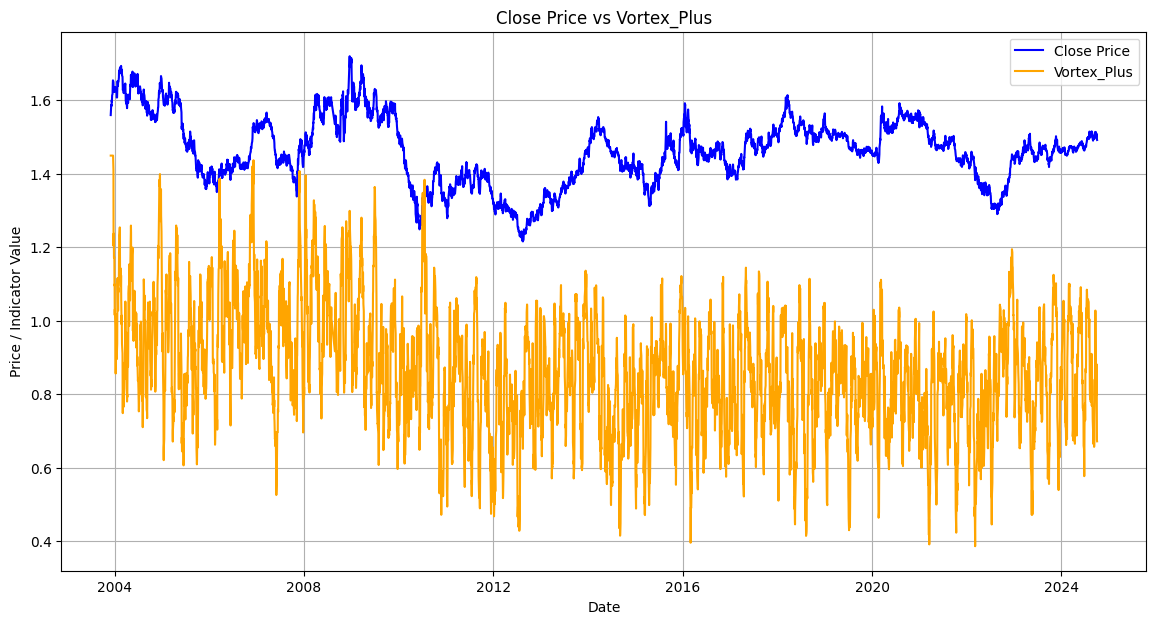

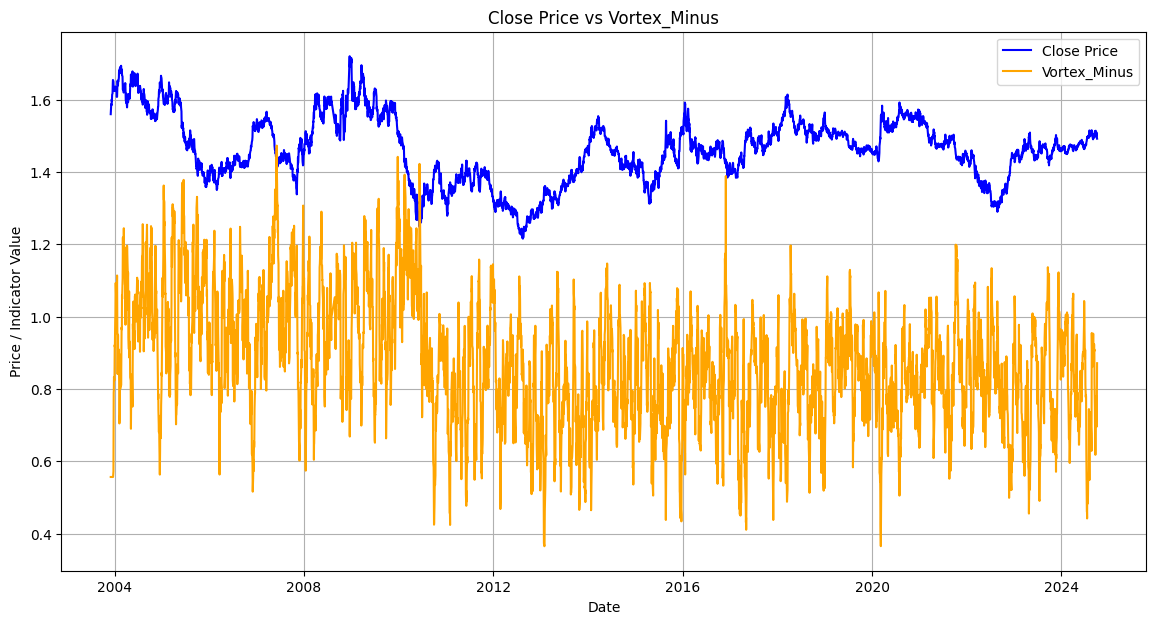

In [17]:
# Plot Close Price vs each indicator
for indicator in indicators:
    if indicator in data.columns:  # Check if the indicator exists
        plot_prices_vs_indicators(data, indicator, f'Close Price vs {indicator}')

# **STEP 5 FIND UN-RELATED FEATURES USING MUTUAL INFORMATION (MI)**

**5.1. Calculate MI and decide which feature has the highest correlation**

In [18]:
# Define the target variables
targets = ['Close', 'Open', 'High', 'Low']  # Add any other targets you want to consider

# Initialize a DataFrame to hold MI scores for each target
mi_results = pd.DataFrame()

# Separate features
X = data.drop(columns=['Date'] + targets)  # Exclude the target and date columns

# Calculate Mutual Information for each target variable
for target in targets:
    y = data[target]
    
    # Calculate Mutual Information
    mi_scores = mutual_info_regression(X, y)
    
    # Create a DataFrame for the current target's MI scores
    mi_df = pd.DataFrame(mi_scores, index=X.columns, columns=[f'MI Score_{target}'])
    
    # Append to the results DataFrame
    mi_results = pd.concat([mi_results, mi_df], axis=1)

# Set display options to avoid scientific notation
pd.set_option('display.float_format', '{:.6f}'.format)

# Display the MI scores for all targets
print("Mutual Information Scores for each target:")
print(mi_results)

Mutual Information Scores for each target:
              MI Score_Close  MI Score_Open  MI Score_High  MI Score_Low
Adj Close           7.272347       4.496309       3.200637      3.214597
Volume              0.000033       0.000000       0.000000      0.000000
MA_10               1.967399       2.031642       1.969626      1.991212
MA_50               1.339021       1.348052       1.375006      1.388444
MA_200              1.079590       1.087906       1.139658      1.161947
RSI                 0.160345       0.133626       0.098497      0.100960
MACD                0.223624       0.244604       0.227986      0.234636
BB_High             1.673457       1.691827       1.672768      1.699845
BB_Low              1.655104       1.677506       1.671223      1.687914
BB_Width            0.186582       0.184969       0.211877      0.206542
Volume_24h          0.000006       0.000000       0.000000      0.000000
ADL                 0.000002       0.000000       0.000000      0.000000
Aroon_Up

**5.2. Drop unrelated features**

In [19]:
# Define a threshold for MI score
mi_threshold = 0.25

# Identify features to drop based on the MI score for each target
features_to_drop = set()
for target in targets:
    low_mi_features = mi_results[mi_results[f'MI Score_{target}'] < mi_threshold].index.tolist()
    features_to_drop.update(low_mi_features)

# Drop the unrelated features from the DataFrame
X_reduced = X.drop(columns=list(features_to_drop))

# Optionally, update the DataFrame with the target
data_reduced = data.drop(columns=list(features_to_drop))

# Check the remaining features
print("Remaining features after dropping unrelated ones:")
print(X_reduced.columns)

# Save the reduced DataFrame if needed
reduced_file_path = os.path.join('Dataset', forex_label[0] + '_reduced_data.csv')
data_reduced.to_csv(reduced_file_path, index=False)
print(f"Saved reduced data to: {reduced_file_path}")
print(data.head(1000))

Remaining features after dropping unrelated ones:
Index(['Adj Close', 'MA_10', 'MA_50', 'MA_200', 'BB_High', 'BB_Low', 'ATR'], dtype='object')
Saved reduced data to: Dataset\EURCAD=X_reduced_data.csv
          Date     Open     High      Low    Close  Adj Close  Volume  \
0   2003-12-01 1.561600 1.566700 1.554200 1.559600   1.559600       0   
1   2003-12-02 1.559800 1.570800 1.559000 1.567000   1.567000       0   
2   2003-12-03 1.566500 1.576200 1.564800 1.575900   1.575900       0   
3   2003-12-04 1.575400 1.590900 1.569000 1.582900   1.582900       0   
4   2003-12-05 1.583300 1.588600 1.575200 1.587600   1.587600       0   
..         ...      ...      ...      ...      ...        ...     ...   
995 2007-09-27 1.418800 1.421100 1.413900 1.417600   1.417600       0   
996 2007-09-28 1.417100 1.419000 1.410500 1.415200   1.415200       0   
997 2007-10-01 1.416400 1.418750 1.410100 1.412000   1.412000       0   
998 2007-10-02 1.411900 1.416660 1.409700 1.413100   1.413100       0 

# **STEP 6: PREPARE AND TRANSFORM DATA-FRAME**

In [20]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names):
        self.feature_names = feature_names

    def fit(self, dataframe, labels=None):
        return self

    def transform(self, dataframe):
        return dataframe[self.feature_names].values

**6.1. Shift Label for future predictions**

In [21]:
k = -1
for target_column in targets:  # Iterate over each target
    data[target_column] = data[target_column].shift(k)

# Drop rows with NaN values created by the shift
data = data.dropna()

# Print some data 
print(data.head())

        Date     Open     High      Low    Close  Adj Close  Volume    MA_10  \
0 2003-12-01 1.559800 1.570800 1.559000 1.567000   1.559600       0 1.587570   
1 2003-12-02 1.566500 1.576200 1.564800 1.575900   1.567000       0 1.587570   
2 2003-12-03 1.575400 1.590900 1.569000 1.582900   1.575900       0 1.587570   
3 2003-12-04 1.583300 1.588600 1.575200 1.587600   1.582900       0 1.587570   
4 2003-12-05 1.587700 1.593900 1.582700 1.584600   1.587600       0 1.587570   

     MA_50   MA_200  ...      ATR       AO       BOP  Bull_Power  Bear_Power  \
0 1.628962 1.630843  ... 0.000000 0.010612 -0.159999    0.061038    0.043338   
1 1.628962 1.630843  ... 0.000000 0.010612  0.610173    0.061038    0.043338   
2 1.628962 1.630843  ... 0.000000 0.010612  0.824563    0.061038    0.043338   
3 1.628962 1.630843  ... 0.000000 0.010612  0.342469    0.061038    0.043338   
4 1.628962 1.630843  ... 0.000000 0.010612  0.320894    0.061038    0.043338   

   Chaikin_Osc  Stoch_Osc       CCI  V

**6.2. Split the data into training and test sets**

In [22]:
train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)

# Print out some information about the split
print('\n____________ Split training and test set ____________')     
print(len(train_set), "training +", len(test_set), "test examples")
print(train_set.head(4))


____________ Split training and test set ____________
4329 training + 1083 test examples
           Date     Open     High      Low    Close  Adj Close  Volume  \
1323 2009-01-27 1.619400 1.628100 1.590900 1.595600   1.618700       0   
1583 2010-01-26 1.495200 1.499500 1.490900 1.492100   1.495400       0   
2052 2011-11-15 1.380900 1.386000 1.378900 1.380900   1.385100       0   
4674 2021-12-06 1.439700 1.440290 1.421190 1.440040   1.448820       0   

        MA_10    MA_50   MA_200  ...      ATR        AO       BOP  Bull_Power  \
1323 1.630430 1.640764 1.584250  ... 0.031084 -0.041164  0.417217   -0.015964   
1583 1.484960 1.528336 1.560744  ... 0.012646 -0.018361  0.018511   -0.025536   
2052 1.391516 1.388102 1.383907  ... 0.015138 -0.008537  0.016981   -0.000212   
4674 1.436163 1.441557 1.473803  ... 0.011957  0.011137 -0.004835    0.009363   

      Bear_Power  Chaikin_Osc  Stoch_Osc         CCI  Vortex_Plus  \
1323   -0.031064     0.000000  48.255801  -54.815129     1.04433

**6.3. Define features and targets**

In [23]:
feature_columns = data.columns.difference(['Date'] + targets).tolist()  # Define features excluding Date and targets
X_reduced = data.drop(columns=['Date'] + targets).drop(columns=list(features_to_drop))  

In [24]:
X_train = train_set[X_reduced.columns]
X_test = test_set[X_reduced.columns]

# Split targets for each label
y_train_dict = {target: train_set[target] for target in targets}
y_test_dict = {target: test_set[target] for target in targets}

**6.4. Define and Train Model Pipelines for Each Target**

In [25]:

# Redefine num_feat_names based on X_reduced
num_feat_names = X_reduced.columns.tolist()

In [26]:
num_pipeline = Pipeline(steps=[
    ('selector', ColumnSelector(num_feat_names)),
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('scaler', StandardScaler(with_mean=True, with_std=True))
])


**6.4.2. Fit and Transform the Pipeline on training data**

In [27]:

# Run the pipeline to process training data
processed_train_set_val = num_pipeline.fit_transform(X_train)

# Fit the pipeline on training data and transform both training and test data
X_train = num_pipeline.fit_transform(X_train)
X_test = num_pipeline.transform(X_test)

# Convert the transformed data back to DataFrame with appropriate column names
X_train = pd.DataFrame(X_train, columns=num_feat_names)
X_test = pd.DataFrame(X_test, columns=num_feat_names)

print('\n____________ Processed feature values ____________')
print(processed_train_set_val[:3, :])  # Print out some of the first rows of the training dataset after fit_transforming
print(processed_train_set_val.shape)  # Print out the statistics of the training set

# Save the numerical pipeline
joblib.dump(num_pipeline, r'models/num_pipeline.pkl')


____________ Processed feature values ____________
[[ 1.73177306  1.86961992  2.01106983  1.43489251  2.23026496  1.55046958
   4.24136304]
 [ 0.3668788   0.25170124  0.74043102  1.15317318  0.27398211  0.35685346
  -0.08071527]
 [-0.85410798 -0.78758368 -0.84446572 -0.96617832 -0.82998131 -0.64623609
   0.50346405]]
(4329, 7)


['models/num_pipeline.pkl']

# **STEP 7. TRAIN AND EVALUATE MODEL**

**Function to calculate R2 score and Root Mean Squared Error.**

In [28]:
def r2score_and_rmse(model, train_data, labels): 
    r2score = model.score(train_data, labels)
    from sklearn.metrics import mean_squared_error
    prediction = model.predict(train_data)
    mse = mean_squared_error(labels, prediction)
    rmse = np.sqrt(mse)
    return r2score, rmse

**Function to Store and Load Models.**

In [29]:
def store_model(model, model_name = ""):
    # NOTE: sklearn.joblib faster than pickle of Python
    # INFO: can store only ONE object in a file
    if model_name == "": 
        model_name = type(model).__name__
    joblib.dump(model,'models/' + model_name + '_model.pkl')
    print(f"Model successfully saved as " + model_name + '_model.pkl')
    
def load_model(model_name):
    # Load objects into memory
    #del model
    model = joblib.load('models/' + model_name + '_model.pkl')
    #print(model)
    return model

**7.1. Try Light GBM model.**

In [30]:
for target in targets:
    model = lgb.LGBMRegressor()  # Initialize the model
    model.fit(X_train, y_train_dict[target])  # Fit the model on the respective target

    print(f'\n____________ LGBMRegressor for {target} ____________')

    r2score, rmse = r2score_and_rmse(model, X_train, y_train_dict[target])
    print('\nR2 score (on training data, best=1):', r2score)
    print("Root Mean Square Error: ", rmse)

    # Predict labels for some test instances
    print("\nPredictions: ", model.predict(X_test[:9]))
    print("Labels:      ", list(y_test_dict[target][:9]))

    store_model(model)  # Store the model for the current target

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000556 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 4329, number of used features: 7
[LightGBM] [Info] Start training from score 1.462331

____________ LGBMRegressor for Close ____________

R2 score (on training data, best=1): 0.9946525370933091
Root Mean Square Error:  0.006611685141297647

Predictions:  [1.59822928 1.32478087 1.52038603 1.4584361  1.51418689 1.40726015
 1.40612289 1.59926103 1.34904206]
Labels:       [1.5925999879837036, 1.3309999704360962, 1.5217000246047974, 1.4508999586105347, 1.4993000030517578, 1.4077999591827393, 1.4088000059127808, 1.5987000465393066, 1.353700041770935]
Model successfully saved as LGBMRegressor_model.pkl

**7.2. Try XGBoost model.**

In [31]:
for target in targets:
    model = XGBRegressor() # Initialize the model
    model.fit(X_train, y_train_dict[target])  # Fit the model on the respective target

    print(f'\n____________ XGBoost_Regressor for {target} ____________')

    r2score, rmse = r2score_and_rmse(model, X_train, y_train_dict[target])
    print('\nR2 score (on training data, best=1):', r2score)
    print("Root Mean Square Error: ", rmse)

    # Predict labels for some test instances
    print("\nPredictions: ", model.predict(X_test[:9]))
    print("Labels:      ", list(y_test_dict[target][:9]))

    store_model(model)  # Store the model for the current target


____________ XGBoost_Regressor for Close ____________

R2 score (on training data, best=1): 0.9979809659873822
Root Mean Square Error:  0.004062656376453302

Predictions:  [1.5980368 1.3270974 1.5233157 1.457394  1.5096799 1.4037467 1.4132602
 1.6029743 1.3480774]
Labels:       [1.5925999879837036, 1.3309999704360962, 1.5217000246047974, 1.4508999586105347, 1.4993000030517578, 1.4077999591827393, 1.4088000059127808, 1.5987000465393066, 1.353700041770935]
Model successfully saved as XGBRegressor_model.pkl

____________ XGBoost_Regressor for Open ____________

R2 score (on training data, best=1): 0.998875521623831
Root Mean Square Error:  0.003029912531390111

Predictions:  [1.5958846 1.3251495 1.5251805 1.4570279 1.5126767 1.4055749 1.4077406
 1.5958487 1.3438197]
Labels:       [1.5981999635696411, 1.330899953842163, 1.5216100215911865, 1.450700044631958, 1.5068999528884888, 1.4077999591827393, 1.4086999893188477, 1.5973000526428223, 1.3535000085830688]
Model successfully saved as XGBR

**7.3. Try Decision Tree (in-lecture).**

In [32]:
for target in targets:
    model = DecisionTreeRegressor() # Initialize the model
    model.fit(X_train, y_train_dict[target])  # Fit the model on the respective target

    print(f'\n____________ DecisionTreeRegressor for {target} ____________')

    r2score, rmse = r2score_and_rmse(model, X_train, y_train_dict[target])
    print('\nR2 score (on training data, best=1):', r2score)
    print("Root Mean Square Error: ", rmse)

    # Predict labels for some test instances
    print("\nPredictions: ", model.predict(X_test[:9]))
    print("Labels:      ", list(y_test_dict[target][:9]))

    store_model(model)  # Store the model for the current target


____________ DecisionTreeRegressor for Close ____________

R2 score (on training data, best=1): 1.0
Root Mean Square Error:  0.0

Predictions:  [1.59829998 1.32690001 1.52090001 1.45930004 1.50680006 1.40568995
 1.40030003 1.59730005 1.35160005]
Labels:       [1.5925999879837036, 1.3309999704360962, 1.5217000246047974, 1.4508999586105347, 1.4993000030517578, 1.4077999591827393, 1.4088000059127808, 1.5987000465393066, 1.353700041770935]
Model successfully saved as DecisionTreeRegressor_model.pkl

____________ DecisionTreeRegressor for Open ____________

R2 score (on training data, best=1): 1.0
Root Mean Square Error:  0.0

Predictions:  [1.59809995 1.32079995 1.52310002 1.45930004 1.51681006 1.40470004
 1.39979994 1.59730005 1.34920001]
Labels:       [1.5981999635696411, 1.330899953842163, 1.5216100215911865, 1.450700044631958, 1.5068999528884888, 1.4077999591827393, 1.4086999893188477, 1.5973000526428223, 1.3535000085830688]
Model successfully saved as DecisionTreeRegressor_model.pkl


**7.4. Try Polynomial Regression (in-lecture).**

In [33]:
for target in targets:
    degree = 2  # Degree of the polynomial
    model = Pipeline([
        ('poly_features', PolynomialFeatures(degree=degree)),
        ('lin_reg', LinearRegression())
    ])

    # Fit the model on the respective target
    model.fit(X_train, y_train_dict[target])

    print(f'\n____________ PolynomialRegressor for {target} ____________')

    r2score, rmse = r2score_and_rmse(model, X_train, y_train_dict[target])
    print('\nR2 score (on training data, best=1):', r2score)
    print("Root Mean Square Error: ", rmse)

    # Predict labels for some test instances
    predictions = model.predict(X_test[:9]).round(decimals=1)
    print("\nPredictions: ", predictions)
    print("Labels:      ", list(y_test_dict[target][:9]))

    store_model(model)  # Store the model for the current target


____________ PolynomialRegressor for Close ____________

R2 score (on training data, best=1): 0.9918055638916398
Root Mean Square Error:  0.008184606608294237

Predictions:  [1.6 1.3 1.5 1.5 1.5 1.4 1.4 1.6 1.3]
Labels:       [1.5925999879837036, 1.3309999704360962, 1.5217000246047974, 1.4508999586105347, 1.4993000030517578, 1.4077999591827393, 1.4088000059127808, 1.5987000465393066, 1.353700041770935]
Model successfully saved as Pipeline_model.pkl

____________ PolynomialRegressor for Open ____________

R2 score (on training data, best=1): 0.9951458127091067
Root Mean Square Error:  0.006295247389152453

Predictions:  [1.6 1.3 1.5 1.5 1.5 1.4 1.4 1.6 1.3]
Labels:       [1.5981999635696411, 1.330899953842163, 1.5216100215911865, 1.450700044631958, 1.5068999528884888, 1.4077999591827393, 1.4086999893188477, 1.5973000526428223, 1.3535000085830688]
Model successfully saved as Pipeline_model.pkl

____________ PolynomialRegressor for High ____________

R2 score (on training data, best=1): 

**7.5. Try Linear Regressor (in-lecture).**

In [34]:
for target in targets:
    model = LinearRegression() # Initialize the model
    model.fit(X_train, y_train_dict[target])  # Fit the model on the respective target

    print(f'\n____________ Linear Regressor for {target} ____________')

    r2score, rmse = r2score_and_rmse(model, X_train, y_train_dict[target])
    print('\nR2 score (on training data, best=1):', r2score)
    print("Root Mean Square Error: ", rmse)

    # Predict labels for some test instances
    print("\nPredictions: ", model.predict(X_test[:9]))
    print("Labels:      ", list(y_test_dict[target][:9]))

    store_model(model)  # Store the model for the current target


____________ Linear Regressor for Close ____________

R2 score (on training data, best=1): 0.9916840742129528
Root Mean Square Error:  0.008245055355133271

Predictions:  [1.59801694 1.32092807 1.51959941 1.4592862  1.50706206 1.40648562
 1.40336246 1.59739905 1.34790419]
Labels:       [1.5925999879837036, 1.3309999704360962, 1.5217000246047974, 1.4508999586105347, 1.4993000030517578, 1.4077999591827393, 1.4088000059127808, 1.5987000465393066, 1.353700041770935]
Model successfully saved as LinearRegression_model.pkl

____________ Linear Regressor for Open ____________

R2 score (on training data, best=1): 0.9951143358674551
Root Mean Square Error:  0.006315625085648445

Predictions:  [1.59837316 1.32125609 1.51933699 1.45946142 1.50645161 1.40644184
 1.40367692 1.597406   1.34748658]
Labels:       [1.5981999635696411, 1.330899953842163, 1.5216100215911865, 1.450700044631958, 1.5068999528884888, 1.4077999591827393, 1.4086999893188477, 1.5973000526428223, 1.3535000085830688]
Model succe

**7.6. Try Random Forest (in-lecture).**

In [35]:
for target in targets:
    model = RandomForestRegressor(n_estimators=20) # Initialize the model
    model.fit(X_train, y_train_dict[target])  # Fit the model on the respective target

    print(f'\n____________ RandomForestRegressor for {target} ____________')

    r2score, rmse = r2score_and_rmse(model, X_train, y_train_dict[target])
    print('\nR2 score (on training data, best=1):', r2score)
    print("Root Mean Square Error: ", rmse)

    # Predict labels for some test instances
    print("\nPredictions: ", model.predict(X_test[:9]))
    print("Labels:      ", list(y_test_dict[target][:9]))

    store_model(model)  # Store the model for the current target


____________ RandomForestRegressor for Close ____________

R2 score (on training data, best=1): 0.9984709885621599
Root Mean Square Error:  0.0035354413767681478

Predictions:  [1.600755   1.32661697 1.52226401 1.45859603 1.50857651 1.40826802
 1.39817752 1.59486402 1.35018801]
Labels:       [1.5925999879837036, 1.3309999704360962, 1.5217000246047974, 1.4508999586105347, 1.4993000030517578, 1.4077999591827393, 1.4088000059127808, 1.5987000465393066, 1.353700041770935]
Model successfully saved as RandomForestRegressor_model.pkl

____________ RandomForestRegressor for Open ____________

R2 score (on training data, best=1): 0.9991117063370053
Root Mean Square Error:  0.0026929780843238846

Predictions:  [1.59771003 1.32891701 1.52186903 1.45926751 1.50559152 1.40731999
 1.40060398 1.59767999 1.35375748]
Labels:       [1.5981999635696411, 1.330899953842163, 1.5216100215911865, 1.450700044631958, 1.5068999528884888, 1.4077999591827393, 1.4086999893188477, 1.5973000526428223, 1.353500008583

**7.7. Try K-Nearest-Neighbor**

In [36]:
for target in targets:
    model = KNeighborsRegressor(n_neighbors=5) # Initialize the model
    model.fit(X_train, y_train_dict[target])  # Fit the model on the respective target

    print(f'\n____________ KNeighborRegressor for {target} ____________')

    r2score, rmse = r2score_and_rmse(model, X_train, y_train_dict[target])
    print('\nR2 score (on training data, best=1):', r2score)
    print("Root Mean Square Error: ", rmse)

    # Predict labels for some test instances
    print("\nPredictions: ", model.predict(X_test[:9]))
    print("Labels:      ", list(y_test_dict[target][:9]))

    store_model(model)  # Store the model for the current target


____________ KNeighborRegressor for Close ____________

R2 score (on training data, best=1): 0.9945020268733378
Root Mean Square Error:  0.006704086043829559

Predictions:  [1.60152001 1.33362999 1.51646202 1.45559001 1.50118001 1.41322999
 1.42520599 1.59542003 1.35518401]
Labels:       [1.5925999879837036, 1.3309999704360962, 1.5217000246047974, 1.4508999586105347, 1.4993000030517578, 1.4077999591827393, 1.4088000059127808, 1.5987000465393066, 1.353700041770935]
Model successfully saved as KNeighborsRegressor_model.pkl

____________ KNeighborRegressor for Open ____________

R2 score (on training data, best=1): 0.9956870616677197
Root Mean Square Error:  0.005933912819420103

Predictions:  [1.60328002 1.33357    1.51647801 1.45546002 1.49928002 1.41328201
 1.425144   1.59302001 1.35523999]
Labels:       [1.5981999635696411, 1.330899953842163, 1.5216100215911865, 1.450700044631958, 1.5068999528884888, 1.4077999591827393, 1.4086999893188477, 1.5973000526428223, 1.3535000085830688]
Mode

**7.8. Try using SVR**

In [37]:
for target in targets:
    model = SVR(kernel='rbf')  # Initialize the model
    model.fit(X_train, y_train_dict[target])  # Fit the model on the respective target

    print(f'\n____________ Support Vector Regressor (SVR) for {target} ____________')

    r2score, rmse = r2score_and_rmse(model, X_train, y_train_dict[target])
    print('\nR2 score (on training data, best=1):', r2score)
    print("Root Mean Square Error: ", rmse)

    # Predict labels for some test instances
    print("\nPredictions: ", model.predict(X_test[:9]))
    print("Labels:      ", list(y_test_dict[target][:9]))

    store_model(model)  # Store the model for the current target


____________ Support Vector Regressor (SVR) for Close ____________

R2 score (on training data, best=1): 0.7523396863302083
Root Mean Square Error:  0.04499523066860656

Predictions:  [1.57318546 1.38313524 1.49469074 1.49375121 1.49144577 1.45214675
 1.459587   1.56541607 1.42822017]
Labels:       [1.5925999879837036, 1.3309999704360962, 1.5217000246047974, 1.4508999586105347, 1.4993000030517578, 1.4077999591827393, 1.4088000059127808, 1.5987000465393066, 1.353700041770935]
Model successfully saved as SVR_model.pkl

____________ Support Vector Regressor (SVR) for Open ____________

R2 score (on training data, best=1): 0.74637719590402
Root Mean Square Error:  0.04550390699727683

Predictions:  [1.56894957 1.38653823 1.49205152 1.49155602 1.48916611 1.45193936
 1.46063632 1.56052877 1.42833111]
Labels:       [1.5981999635696411, 1.330899953842163, 1.5216100215911865, 1.450700044631958, 1.5068999528884888, 1.4077999591827393, 1.4086999893188477, 1.5973000526428223, 1.3535000085830688]


# **STEP 8: EVALUATE WITH K-CROSS VALIDATION:**

In [38]:
# Ensure directories exist
os.makedirs('saved_objects', exist_ok=True)
os.makedirs('models', exist_ok=True)

print('\n____________ K-fold cross validation ____________')
cv = KFold(n_splits=5, shuffle=True, random_state=37)  # cv data generator

run_new_evaluation = 0  # Set to 1 for new evaluation; 0 to load results
filename_prefix = "your_prefix"  # Change this to your desired prefix

if run_new_evaluation:
    models = {
        "LinearRegression": LinearRegression(),
        "LGBMRegressor": lgb.LGBMRegressor(),
        "XGBoost": XGBRegressor(),
        "DecisionTreeRegressor": DecisionTreeRegressor(),
        "RandomForestRegressor": RandomForestRegressor(n_estimators=20),
        "KNeighborsRegressor": KNeighborsRegressor(n_neighbors=5),
        "SVR": SVR(kernel='rbf')
    }
    
    for model_name, model in models.items():
        for target in targets:
            print(f"\nEvaluating {model_name} for {target}...")
            y_train = y_train_dict[target]
            
            try:
                nmse_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
                rmse_scores = np.sqrt(-nmse_scores)
                
                # Save RMSE scores
                joblib.dump(rmse_scores, f'saved_objects/{model_name}_rmse_{target}.pkl')
                print(f"{target} - {model_name} rmse: ", rmse_scores)
                print(f"{target} - Avg. rmse: ", mean(rmse_scores), '\n')

                # Predict using cross-validation
                y_train_pred = cross_val_predict(model, X_train, y_train, cv=cv)
                
                # Calculate residuals
                residuals = y_train - y_train_pred
                
                # Plot the residual distribution
                plt.figure()
                plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
                plt.title(f'{target} - {model_name} Residual Distribution')
                plt.xlabel('Residuals')
                plt.ylabel('Frequency')
                plt.grid(True)
                plt.savefig(f'models/{filename_prefix}_{target}_{model_name}_residuals_plot.png')  # Save with target name
                plt.show()  # Display the plot (useful in Jupyter Notebooks)
                plt.close()  # Close the plot to free memory
            except Exception as e:
                print(f"Error evaluating {model_name} for {target}: {e}")
else: 
    # Load RMSE scores from previously saved files
    for model_name in ["LinearRegression", "LGBMRegressor", "XGBoost", "DecisionTreeRegressor", "RandomForestRegressor", "KNeighborsRegressor", "SVR"]:
        for target in targets:
            try:
                rmse_scores = joblib.load(f'saved_objects/{model_name}_rmse_{target}.pkl')
                print(f"\n{model_name} rmse for {target}: ", rmse_scores)
                print(f"Avg. rmse for {target}: ", mean(rmse_scores), '\n')
            except FileNotFoundError:
                print(f"File not found for {model_name} and {target}. Ensure you've run the evaluation first.")



____________ K-fold cross validation ____________

LinearRegression rmse for Close:  [0.00816052 0.00832279 0.00826111 0.00805167 0.00848984]
Avg. rmse for Close:  0.008257186208295419 


LinearRegression rmse for Open:  [0.0062861  0.00652489 0.00624347 0.00617211 0.0064021 ]
Avg. rmse for Open:  0.006325734099407124 


LinearRegression rmse for High:  [0.00825374 0.00854366 0.0079518  0.00801179 0.00816728]
Avg. rmse for High:  0.008185652501419735 


LinearRegression rmse for Low:  [0.00756071 0.00777286 0.00767106 0.00777905 0.00794594]
Avg. rmse for Low:  0.007745924327178572 


LGBMRegressor rmse for Close:  [0.00874258 0.00911576 0.00866867 0.00850613 0.00919192]
Avg. rmse for Close:  0.008845010923418732 


LGBMRegressor rmse for Open:  [0.0067708  0.00708219 0.00655369 0.00663943 0.00675671]
Avg. rmse for Open:  0.006760563359364989 


LGBMRegressor rmse for High:  [0.00834373 0.00895931 0.00797628 0.00817708 0.008369  ]
Avg. rmse for High:  0.008365080191368059 


LGBMRegres

**STEP 9: FINE-TUNING**

In [39]:
print('\n____________ Fine-tune models ____________')

# Function to print results of grid search
def print_search_result(grid_search, model_name=""):
    print("\n====== Fine-tune " + model_name + " ======")
    print('Best hyperparameter combination: ', grid_search.best_params_)
    print('Best rmse: ', np.sqrt(-grid_search.best_score_)) 
    print('Performance of hyperparameter combinations:')
    cv_results = grid_search.cv_results_
    for (mean_score, params) in zip(cv_results["mean_test_score"], cv_results["params"]):
        print('rmse =', np.sqrt(-mean_score), params)

cv = KFold(n_splits=5, shuffle=True, random_state=37)

run_new_search = 0  # Set to 1 to run a new search, 0 to load previous results
if run_new_search:
    # Define a parameter grid for LightGBM
    param_grid = {
        'n_estimators': [100, 200, 500],  # Number of boosting iterations (trees) to be built.
        'max_depth': [3, 5, 7, 10],  # Maximum depth of each tree.
        'learning_rate': [0.01, 0.05, 0.1],  # Step size shrinkage used to prevent overfitting
        'subsample': [0.8, 0.9, 1.0],  # Fraction of samples used for training each tree
        'colsample_bytree': [0.8, 0.9, 1.0],  # Fraction of features used for training each tree
        'reg_alpha': [0, 0.1, 0.5],  # L1 regularization term on weights
        'reg_lambda': [0, 0.1, 0.5]  # L2 regularization term on weights
    }
    
    # Set up and run grid search
    lgb_model = LGBMRegressor(random_state=42)
    grid_search = GridSearchCV(estimator=lgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)

    # Save grid search results
    joblib.dump(grid_search, 'saved_objects/LGBMRegressor_gridsearch.pkl')

    # Print search results
    print_search_result(grid_search, "LGBMRegressor")

    # Get best model from grid search
    best_model = grid_search.best_estimator_

    # Make predictions on training data
    y_train_pred = best_model.predict(X_train)

else:
    # Load previously saved grid search results
    grid_search = joblib.load('saved_objects/LGBMRegressor_gridsearch.pkl')
    print_search_result(grid_search, model_name="LGBMRegressor")
    
    # Get best model from grid search
    best_model = grid_search.best_estimator_
    
    # Make predictions on training data
    y_train_pred = best_model.predict(X_train)



____________ Fine-tune models ____________

====== Fine-tune LGBMRegressor ======
Best hyperparameter combination:  {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'reg_alpha': 0, 'reg_lambda': 0.1, 'subsample': 0.8}
Best rmse:  0.007800774658337827
Performance of hyperparameter combinations:
rmse = 0.03501672795950499 {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 0.8}
rmse = 0.03501672795950499 {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 0.9}
rmse = 0.03501672795950499 {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 1.0}
rmse = 0.035031914582686834 {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 0.1, 'subsample': 0.8}
rmse = 0

# **STEP 10:  PREDICT THE PRICE FOR THE NEXT 7 DAYS USING ALL PAST DATA**

In [40]:
print(X_test.columns)

Index(['Adj Close', 'MA_10', 'MA_50', 'MA_200', 'BB_High', 'BB_Low', 'ATR'], dtype='object')


In [41]:
noise_factor = 0.05

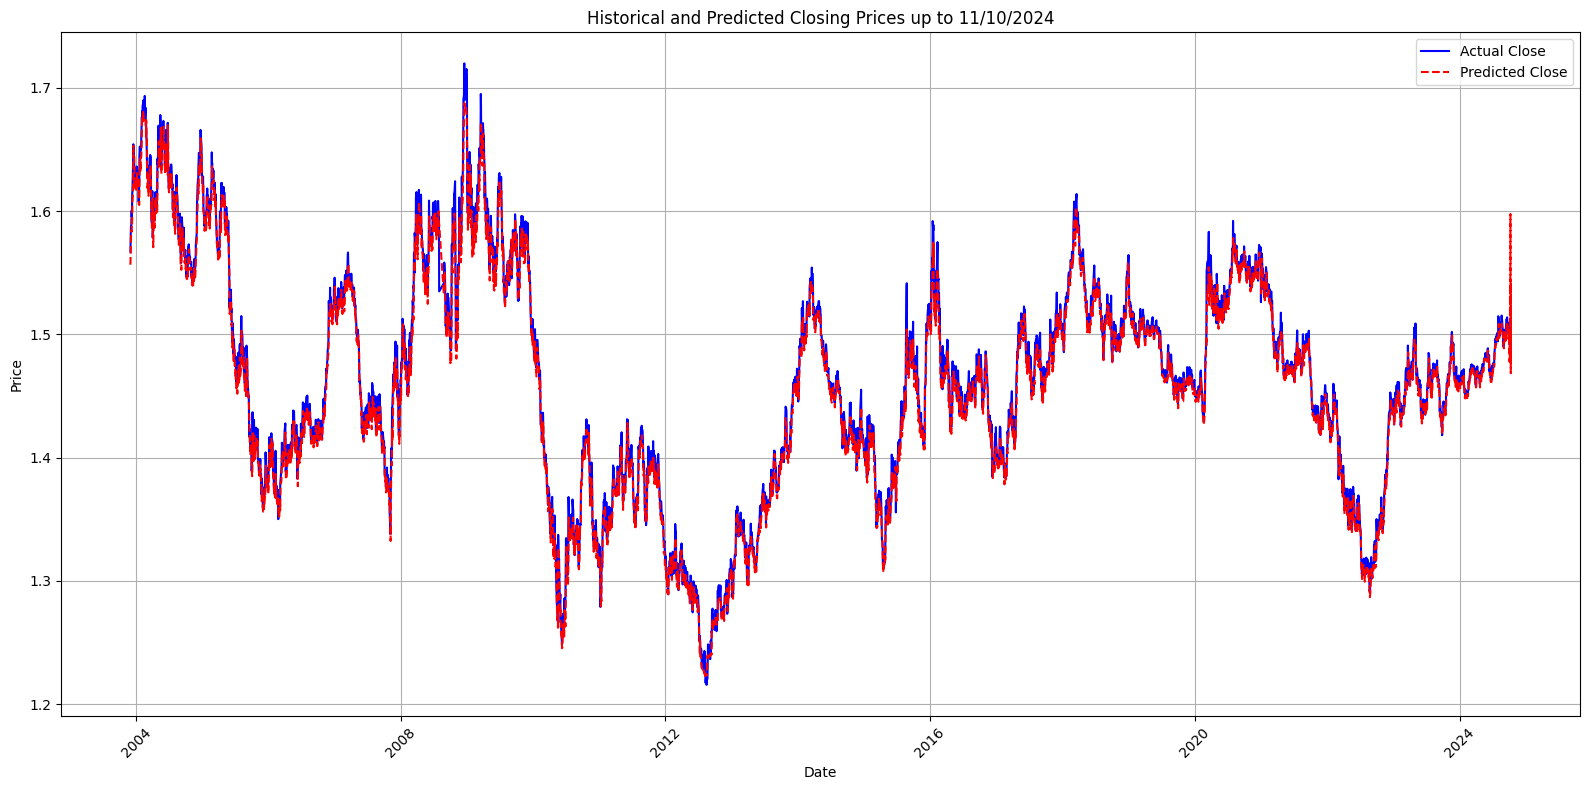

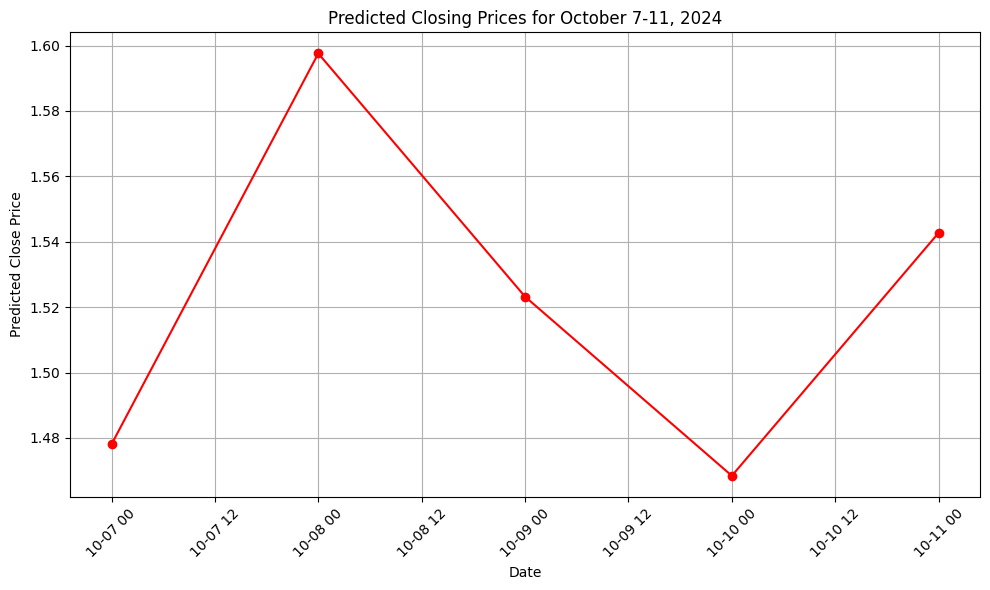


Predicted Closing Prices for October 7-11, 2024:
2024-10-07: 1.48
2024-10-08: 1.60
2024-10-09: 1.52
2024-10-10: 1.47
2024-10-11: 1.54


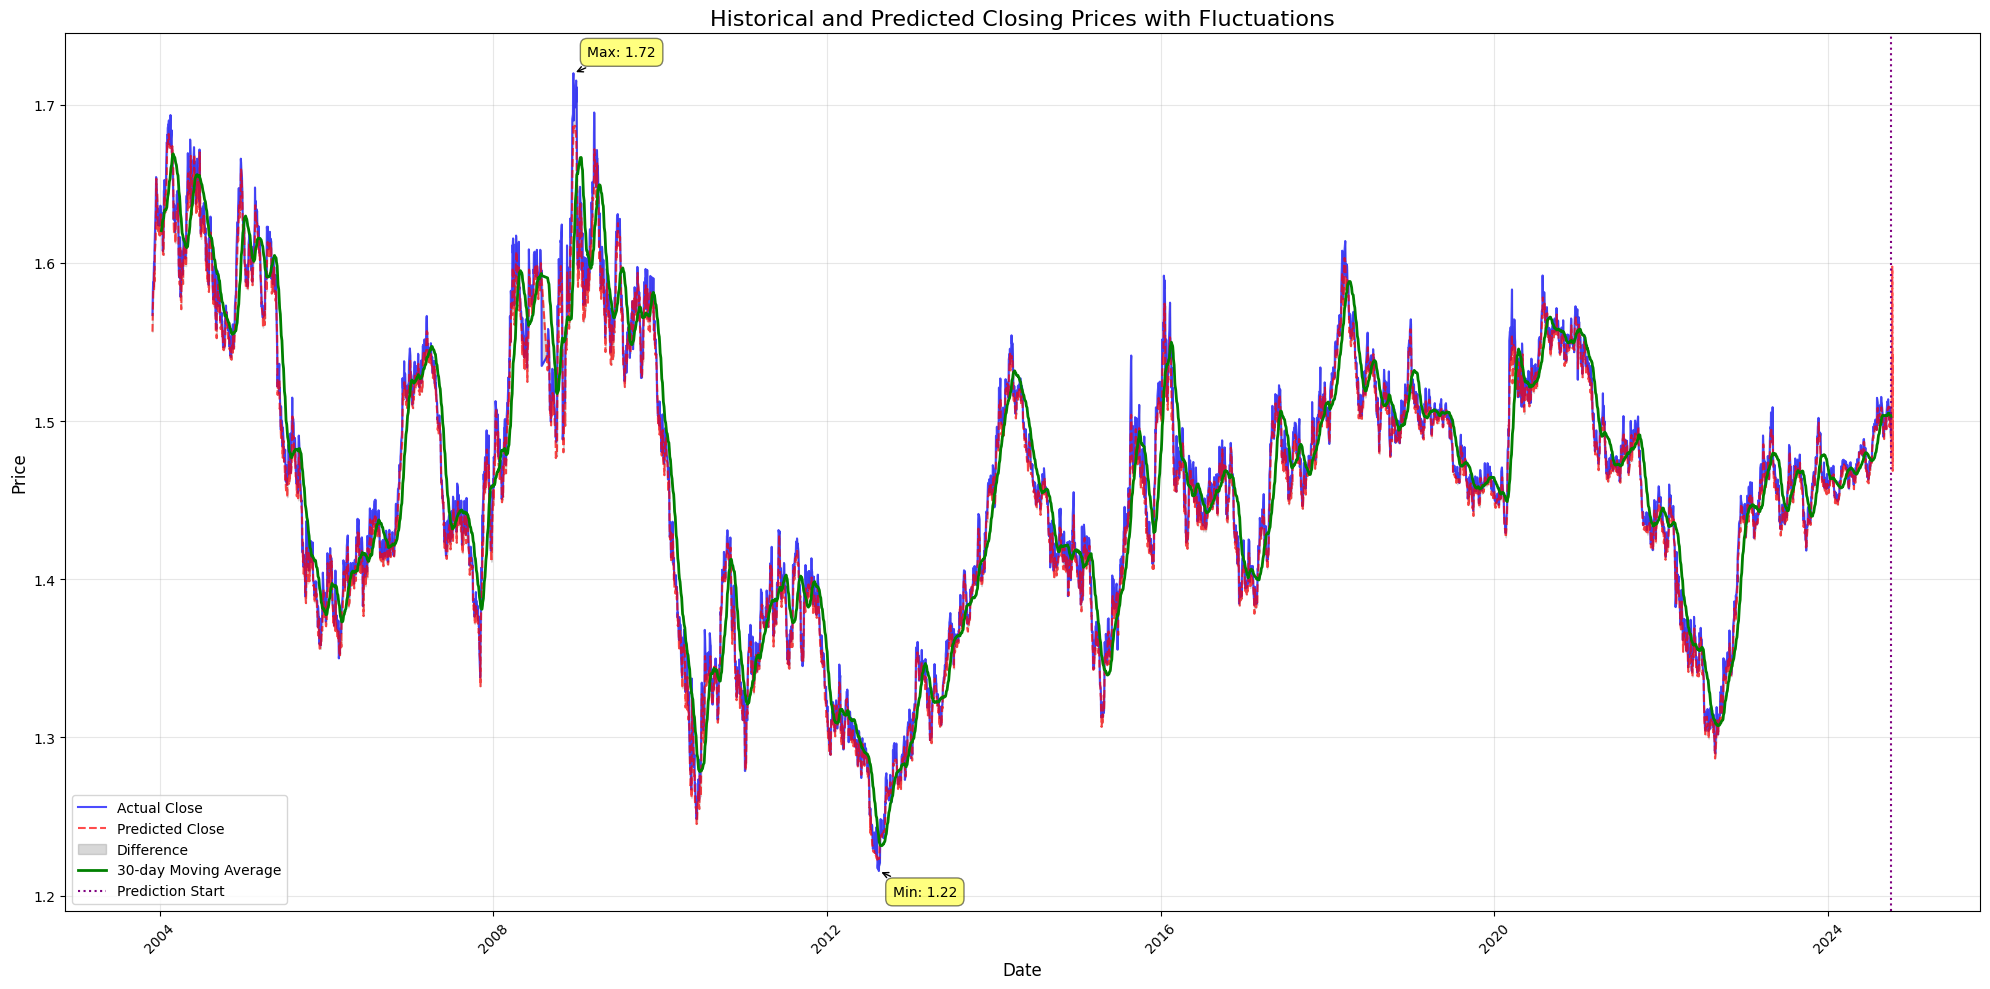

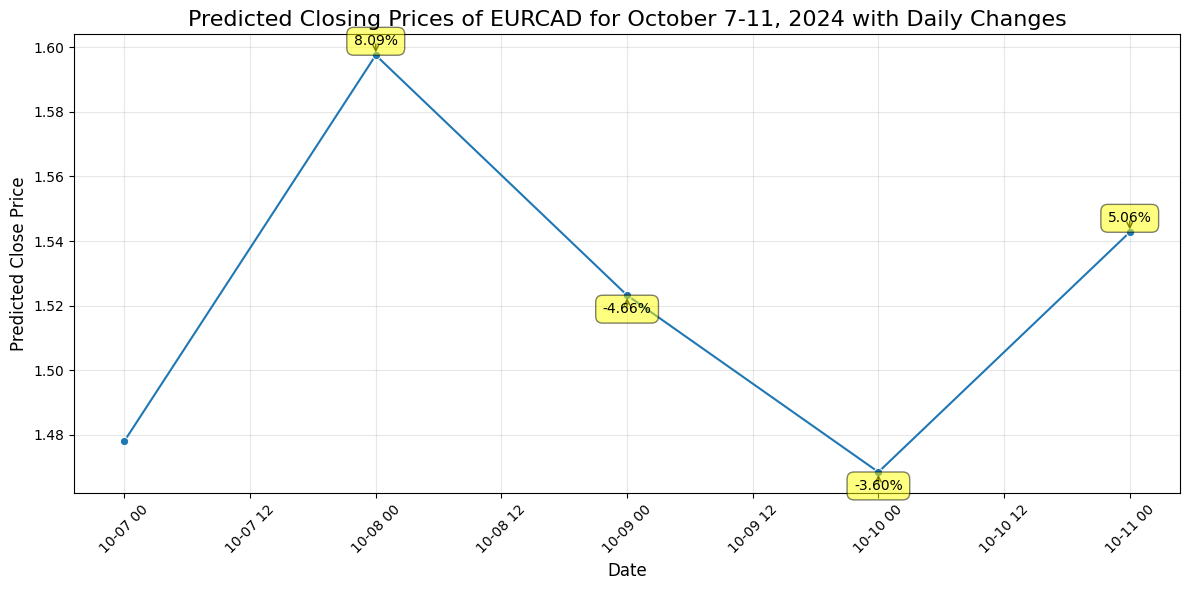


Predicted Closing Prices and Daily Changes of GBPJPY for October 7-11, 2024:
2024-10-07: 1.48
2024-10-08: 1.60 (Change: 8.09%)
2024-10-09: 1.52 (Change: -4.66%)
2024-10-10: 1.47 (Change: -3.60%)
2024-10-11: 1.54 (Change: 5.06%)


In [47]:
# # **STEP 10: FINAL PREDICTION AND VISUALIZATION USING LIGHTGBM**

# import matplotlib.pyplot as plt
# import pandas as pd
# import numpy as np
# from datetime import datetime, timedelta
# import joblib
# from sklearn.metrics import r2_score, mean_squared_error

# # Load the trained LightGBM model from step 9
# lightgbm_model = joblib.load('saved_objects/LGBMRegressor_gridsearch.pkl').best_estimator_

# # Load the numerical pipeline
# num_pipeline = joblib.load('models/num_pipeline.pkl')

# def generate_future_features(last_data, end_date):
#     days = (end_date - last_data['Date'].iloc[-1]).days
#     future_dates = pd.date_range(start=last_data['Date'].iloc[-1] + timedelta(days=1), periods=days)
    
#     future_data = pd.DataFrame({'Date': future_dates})
    
#     # Add time-based features
#     future_data['DayOfWeek'] = future_data['Date'].dt.dayofweek
#     future_data['Month'] = future_data['Date'].dt.month
#     future_data['Year'] = future_data['Date'].dt.year
    
#     # For other features, use a simple time series forecast (e.g., moving average) with some noise
#     for col in last_data.columns:
#         if col not in ['Date', 'DayOfWeek', 'Month', 'Year'] + targets:
#             mean_value = last_data[col].rolling(window=30).mean().iloc[-1]
#             std_value = last_data[col].rolling(window=30).std().iloc[-1]
#             future_data[col] = np.random.normal(mean_value, std_value * 0.1, size=len(future_data))
    
#     return future_data

# # Get the last data point from your original dataset
# last_data = data.copy()

# # Add time-based features to historical data
# last_data['DayOfWeek'] = last_data['Date'].dt.dayofweek
# last_data['Month'] = last_data['Date'].dt.month
# last_data['Year'] = last_data['Date'].dt.year

# # Set the end date for prediction
# end_date = datetime(2024, 10, 4)

# # Generate future features
# future_data = generate_future_features(last_data, end_date)

# # Combine historical and future data
# combined_data = pd.concat([last_data, future_data], ignore_index=True)

# # Prepare features for the entire dataset
# X_combined = combined_data.drop(columns=['Date'] + targets)
# X_combined = num_pipeline.transform(X_combined)

# # Make predictions for the entire dataset
# all_predictions = lightgbm_model.predict(X_combined)

# # Add some noise to the predictions to simulate market fluctuations
# noise = np.random.normal(0, 0.0005, size=len(all_predictions))
# all_predictions += noise

# # Create a DataFrame with all dates and predictions
# prediction_df = pd.DataFrame({
#     'Date': combined_data['Date'],
#     'Actual_Close': combined_data['Close'],
#     'Predicted_Close': all_predictions
# })

# # Visualize the predictions
# plt.figure(figsize=(16, 8))
# plt.plot(prediction_df['Date'], prediction_df['Actual_Close'], label='Actual Close', color='blue')
# plt.plot(prediction_df['Date'], prediction_df['Predicted_Close'], label='Predicted Close', color='red', linestyle='--')
# plt.title('Historical and Predicted Closing Prices up to 11/10/2024')
# plt.xlabel('Date')
# plt.ylabel('Price')
# plt.legend()
# plt.grid(True)
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

# # New plot for October 1-4, 2024
# oct_data = prediction_df[(prediction_df['Date'] >= '2024-10-07') & (prediction_df['Date'] <= '2024-10-11')]

# plt.figure(figsize=(12, 6))
# plt.plot(oct_data['Date'], oct_data['Predicted_Close'], marker='o', linestyle='-', color='green')
# plt.title('Predicted Closing Prices for GBP_JPY, 2024')
# plt.xlabel('Date')
# plt.ylabel('Predicted Price')
# plt.grid(True)
# plt.xticks(oct_data['Date'], [date.strftime('%Y-%m-%d') for date in oct_data['Date']], rotation=45)
# for i, price in enumerate(oct_data['Predicted_Close']):
#     plt.annotate(f'{price:.6f}', (oct_data['Date'].iloc[i], price), textcoords="offset points", xytext=(0,10), ha='center')
# plt.tight_layout()
# plt.show()

# # Print the predictions for specific dates
# print("\nPredictions for specific dates:")
# specific_dates = [
#     datetime(2023, 12, 31),
#     datetime(2024, 3, 31),
#     datetime(2024, 6, 30),
#     datetime(2024, 10, 7),
#     datetime(2024, 10, 8),
#     datetime(2024, 10, 9),
#     datetime(2024, 10, 10),
#     datetime(2024, 10, 11)
# ]

# for date in specific_dates:
#     if date in prediction_df['Date'].values:
#         pred = prediction_df[prediction_df['Date'] == date]['Predicted_Close'].values[0]
#         print(f"{date.strftime('%Y-%m-%d')}: {pred:.10f}")

# # Evaluate the model on the historical data
# historical_mask = prediction_df['Actual_Close'].notna()
# y_true = prediction_df.loc[historical_mask, 'Actual_Close']
# y_pred = prediction_df.loc[historical_mask, 'Predicted_Close']

# r2score = r2_score(y_true, y_pred)
# rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# print(f"\nModel Performance on Historical Data:")
# print(f"R2 Score: {r2score:.10f}")
# print(f"RMSE: {rmse:.10f}")

# # Save predictions to CSV without rounding
# prediction_df.to_csv('forex_predictions_to_2024-10-04.csv', index=False, date_format='%Y-%m-%d', float_format='%.10f')
# print("\nPredictions saved to 'forex_predictions_to_2024-10-11.csv'")

noise_factor = 0.05
# **STEP 10: FINAL PREDICTION AND VISUALIZATION USING LIGHTGBM**

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import joblib
from sklearn.metrics import r2_score, mean_squared_error

# Load the trained LightGBM model from step 9
lightgbm_model = joblib.load('saved_objects/LGBMRegressor_gridsearch.pkl').best_estimator_

# Load the numerical pipeline
num_pipeline = joblib.load('models/num_pipeline.pkl')

def generate_future_features(last_data, end_date):
    days = (end_date - last_data['Date'].iloc[-1]).days
    future_dates = pd.date_range(start=last_data['Date'].iloc[-1] + timedelta(days=1), periods=days)
    
    future_data = pd.DataFrame({'Date': future_dates})
    
    # Add time-based features
    future_data['DayOfWeek'] = future_data['Date'].dt.dayofweek
    future_data['Month'] = future_data['Date'].dt.month
    future_data['Year'] = future_data['Date'].dt.year
    
    # For other features, use a simple time series forecast (e.g., moving average) with some noise
    for col in last_data.columns:
        if col not in ['Date', 'DayOfWeek', 'Month', 'Year'] + targets:
            mean_value = last_data[col].rolling(window=30).mean().iloc[-1]
            std_value = last_data[col].rolling(window=30).std().iloc[-1]
            future_data[col] = np.random.normal(mean_value, std_value + noise_factor, size=len(future_data))
    
    return future_data

# Get the last data point from your original dataset
last_data = data.copy()

# Add time-based features to historical data
last_data['DayOfWeek'] = last_data['Date'].dt.dayofweek
last_data['Month'] = last_data['Date'].dt.month
last_data['Year'] = last_data['Date'].dt.year

# Set the end date for prediction (October 11th, 2024)
end_date = datetime(2024, 10, 11)

# Generate future features
future_data = generate_future_features(last_data, end_date)

# Combine historical and future data
combined_data = pd.concat([last_data, future_data], ignore_index=True)

# Prepare features for the entire dataset
X_combined = combined_data.drop(columns=['Date'] + targets)
X_combined = num_pipeline.transform(X_combined)

# Make predictions for the entire dataset
all_predictions = lightgbm_model.predict(X_combined)

# Create a DataFrame with all dates and predictions
prediction_df = pd.DataFrame({
    'Date': combined_data['Date'],
    'Actual_Close': combined_data['Close'],
    'Predicted_Close': all_predictions
})

# Visualize the predictions
plt.figure(figsize=(16, 8))
plt.plot(prediction_df['Date'], prediction_df['Actual_Close'], label='Actual Close', color='blue')
plt.plot(prediction_df['Date'], prediction_df['Predicted_Close'], label='Predicted Close', color='red', linestyle='--')
plt.title('Historical and Predicted Closing Prices up to 11/10/2024')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# New plot for October 7-11, 2024
oct_data = prediction_df[(prediction_df['Date'] >= '2024-10-07') & (prediction_df['Date'] <= '2024-10-11')]

plt.figure(figsize=(10, 6))
plt.plot(oct_data['Date'], oct_data['Predicted_Close'], marker='o', linestyle='-', color='red')
plt.title('Predicted Closing Prices for October 7-11, 2024')
plt.xlabel('Date')
plt.ylabel('Predicted Close Price')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print out the predicted values for October 7-11, 2024
print("\nPredicted Closing Prices for October 7-11, 2024:")
for _, row in oct_data.iterrows():
    print(f"{row['Date'].date()}: {row['Predicted_Close']:.2f}")


import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import joblib
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns

# Visualize the predictions with highlighted fluctuations
plt.figure(figsize=(20, 10))

# Plot actual close prices
plt.plot(prediction_df['Date'], prediction_df['Actual_Close'], label='Actual Close', color='blue', alpha=0.7)

# Plot predicted close prices
plt.plot(prediction_df['Date'], prediction_df['Predicted_Close'], label='Predicted Close', color='red', linestyle='--', alpha=0.7)

# Highlight the difference between actual and predicted
plt.fill_between(prediction_df['Date'], prediction_df['Actual_Close'], prediction_df['Predicted_Close'], 
                 color='gray', alpha=0.3, label='Difference')

# Add a rolling mean to show the trend
window = 30  # Adjust this value to change the smoothing
plt.plot(prediction_df['Date'], prediction_df['Actual_Close'].rolling(window=window).mean(), 
         label=f'{window}-day Moving Average', color='green', linewidth=2)

# Highlight the prediction period
prediction_start = prediction_df[prediction_df['Actual_Close'].isna()]['Date'].min()
plt.axvline(x=prediction_start, color='purple', linestyle=':', label='Prediction Start')

plt.title('Historical and Predicted Closing Prices with Fluctuations', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Add text annotations for max and min points
max_point = prediction_df['Actual_Close'].max()
min_point = prediction_df['Actual_Close'].min()
max_date = prediction_df.loc[prediction_df['Actual_Close'] == max_point, 'Date'].iloc[0]
min_date = prediction_df.loc[prediction_df['Actual_Close'] == min_point, 'Date'].iloc[0]

plt.annotate(f'Max: {max_point:.2f}', xy=(max_date, max_point), xytext=(10, 10), 
             textcoords='offset points', ha='left', va='bottom',
             bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
             arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

plt.annotate(f'Min: {min_point:.2f}', xy=(min_date, min_point), xytext=(10, -10), 
             textcoords='offset points', ha='left', va='top',
             bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
             arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

plt.tight_layout()
plt.show()

# New plot for October 7-11, 2024 with fluctuations
oct_data = prediction_df[(prediction_df['Date'] >= '2024-10-07') & (prediction_df['Date'] <= '2024-10-11')]

plt.figure(figsize=(12, 6))
sns.lineplot(data=oct_data, x='Date', y='Predicted_Close', marker='o')

# Add percentage change annotations
for i in range(1, len(oct_data)):
    prev_close = oct_data['Predicted_Close'].iloc[i-1]
    curr_close = oct_data['Predicted_Close'].iloc[i]
    pct_change = (curr_close - prev_close) / prev_close * 100
    plt.annotate(f'{pct_change:.2f}%', 
                 xy=(oct_data['Date'].iloc[i], curr_close),
                 xytext=(0, 10 if pct_change >= 0 else -10), 
                 textcoords='offset points',
                 ha='center', va='center',
                 bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                 arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

plt.title('Predicted Closing Prices of EURCAD for October 7-11, 2024 with Daily Changes', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Predicted Close Price', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print out the predicted values and daily changes for October 7-11, 2024
print("\nPredicted Closing Prices and Daily Changes of GBPJPY for October 7-11, 2024:")
for i, (_, row) in enumerate(oct_data.iterrows()):
    if i == 0:
        print(f"{row['Date'].date()}: {row['Predicted_Close']:.2f}")
    else:
        prev_close = oct_data['Predicted_Close'].iloc[i-1]
        pct_change = (row['Predicted_Close'] - prev_close) / prev_close * 100
        print(f"{row['Date'].date()}: {row['Predicted_Close']:.2f} (Change: {pct_change:.2f}%)")
